<div class="alert alert-block alert-info">
<center> <h1> DATA MINING MDSAA-BA </h1> </center> <br>
<center> PROJECT 2021/2022 </center>

**Table of Contents** <br>
* [1. Import](#import)
    * [1.1. Import Libraries](#import_libraries)
    * [1.2. Import Dataset](#import_dataset)
* [2. Change Data Types](#change_datatypes)
* [3. Check for Incoherencies](#check_incoherencies)
* [4. Deal with Outliers](#outliers)
* [5. Treatment of Missing Values](#missing_values)
* [6. Feature Engineering](#feature_engineering)
* [7. Feature Selection](#feature_selection)
* [8. PCA](#pca)
* [9. Clustering Algorithms](#clustering_algorithms)
    * [9.1. Hierarchical Clustering](#hierarchical)
    * [9.2. K-Means Algorithm](#kmeans)
    * [9.3. ](#)
    * [9.3. ](#)

## Dúvidas:

## Próximos passos: 

<a class="anchor" id="import_libraries">

## 1.1. Import Libraries

</a>

In [199]:
import pandas as pd
import math
import numpy as np
#! pip install plotly==5.4.0
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.impute import KNNImputer
from patsy import dmatrices
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


#!conda install git
#!pip install -U git+https://github.com/sevamoo/SOMPY.git
#!pip install scikit-image

#from sompy.sompy import SOMFactory
#from sompy.visualization.plot_tools import plot_hex_map
#from sompy.visualization.mapview import View2DPacked
#from sompy.visualization.mapview import View2D
#from sompy.visualization.bmuhits import BmuHitsView
#from pylab import rcParams

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

<a class="anchor" id="import_dataset">

## 1.2. Import Dataset

</a>

In [90]:
insur = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')

print(insur.shape)
insur.head()

(10296, 14)


CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

<a class="anchor" id="change_datatypes">

## 2. Change Data Types

</a>

In [91]:
insur.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [92]:
# ID does not make sense to be a float
insur.CustID = insur.CustID.astype('string') 
# Identify the education degree by only one number
insur.EducDeg = insur.EducDeg.astype('string').str[2]
# Transform GeoLivArea to a string
insur.GeoLivArea = insur.GeoLivArea.astype('string') 
# Transform Children to a string
insur.Children = insur.Children.astype('string') 

insur.dtypes

CustID            string
FirstPolYear     float64
BirthYear        float64
EducDeg           string
MonthSal         float64
GeoLivArea        string
Children          string
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

<a class="anchor" id="check_incoherencies">

## 3. Check for Incoherencies

</a>

In [93]:
# Only makes sense to have FirstPolYear between 1916 and 2016
# Delete 1 line where FirstPolYear = 53784

insur = insur.loc[insur["FirstPolYear"] != 53784.0] 

In [94]:
# Only makes sense to have Birth Years between 1916 and 2016
# Delete 1 line where BirthYear = 1028

insur = insur.loc[insur["BirthYear"] != 1028] 

In [95]:
insur.apply(lambda x: 1 if x.FirstPolYear < x.BirthYear else 0, axis=1).value_counts()

0    8297
1    1997
dtype: int64

There are 1997 observations where FirstPolYear is bigger than BirthYear, meaning the policy would have been created before the birth of the person who owns it. 

Options for dealing with this incoherence:
- Eliminate de column(variable) BirthYear - meh
- Assume the correct value is the one of the policy and use this year for BirthYear - meh
- Replace the observations where this happens for NANs and inpute the value in the next stage(Missing Values) with knn - totil

In [96]:
insur['BirthYear'] = insur.apply(lambda x: None if x.FirstPolYear < x.BirthYear else x.BirthYear, axis=1)

insur.apply(lambda x: 1 if x.FirstPolYear < x.BirthYear else 0, axis=1).value_counts()

0    10294
dtype: int64

In [97]:
# Checking for incoherencies in the the Educ. Try to see if there are people with advanced qualifications who are too young
# to have them. None were ofund.

educ = insur.loc[((insur["EducDeg"] == '3') | (insur["EducDeg"] == '4')) & (insur["BirthYear"] >= 1995)] 
educ

# Aqui há incoerências !!

CustID  FirstPolYear  BirthYear EducDeg  MonthSal GeoLivArea Children  \
762    763.0        1996.0     1995.0       3    1258.0        1.0      1.0   
2560  2561.0        1996.0     1995.0       3    1227.0        4.0      1.0   
6482  6483.0        1997.0     1996.0       3    1382.0        1.0      1.0   
8052  8053.0        1995.0     1995.0       3     389.0        2.0      1.0   
8188  8189.0        1996.0     1995.0       3     779.0        1.0      1.0   
8348  8349.0        1996.0     1995.0       3    1194.0        3.0      0.0   
8613  8614.0        1995.0     1995.0       3     778.0        4.0      1.0   
8898  8899.0        1995.0     1995.0       3    1055.0        2.0      0.0   

      CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
762       383.73        0.58     197.15         482.30      146.25     73.57   
2560      347.85        0.51     316.17         225.05      159.14     34.23   
6482      -54.67        1.03      89.24         587.90      228.82    118.91   
8052      -25.00        1.00      95.13         609.00      171.81     43.12   
8188     1071.77        0.26      43.01        1148.00      107.91     94.24   
8348      551.44        0.39     124.69         451.75      288.61     50.01   
8613       93.69        0.87      57.01         398.40      305.17    113.91   
8898      320.74        0.59     224.71         342.85      220.93      2.89   

      PremWork  
762      85.57  
2560     22.45  
6482     11.56  
8052    146.14  
8188     90.24  
8348     29.23  
8613     52.23  
8898     55.90

In [98]:
def sum_prems(*args):
    total_prem = 0
    for prem in args:
        total_prem += prem
    return total_prem

# Create new column with 0's and 1's
insur['Coherence_Premiums'] = insur.apply(lambda x:1 if (sum_prems(x.PremMotor, x.PremHousehold, x.PremLife, x.PremHealth, x.PremWork) > (x.MonthSal*12)) else 0, axis=1)

# Check whcih observations are incoherencies
premium = insur.loc[insur["Coherence_Premiums"] == 1, ]  # 1 observation
display(premium)

CustID  FirstPolYear  BirthYear EducDeg  MonthSal GeoLivArea Children  \
9149  9150.0        1985.0        NaN       2     987.0        3.0      1.0   

      CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
9149      804.05        0.97      26.34         829.05     28272.0     65.68   

      PremWork  Coherence_Premiums  
9149    138.25                   1

In [99]:
# Remove those observations from the insur dataset
insur = insur.loc[insur['CustID'] != '9150.0']
# Remove column created above
insur.drop('Coherence_Premiums', axis=1, inplace=True)

In [100]:
#checking if there is any case where the client has not spent any amount in premiums
insur.apply(lambda x:1 if sum_prems(x.PremMotor, x.PremHousehold, x.PremLife, x.PremHealth, x.PremWork) == 0 else 0, axis=1).value_counts()

0    10293
dtype: int64

Removed so far
- 1 birthyear
- 1 first polyear
- 1 premiums

<a class="anchor" id="outliers">

## 4. Deal with Outliers

</a>

In [102]:
# Store the number of observations before removing the outliers
before_outliers = insur.shape[0]

In [103]:
insur.shape[0]

10293

### Pair Grid before Outlier Removal 

In [104]:
#grid = sns.PairGrid(data= insur, vars = ['MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', \
#                                        'PremHealth', 'PremLife', 'PremWork'], height = 4)
#grid = grid.map_upper(plt.scatter, color = 'darkseagreen')
#grid = grid.map_diag(plt.hist, bins = 10, color = 'cadetblue')
#grid = grid.map_lower(plt.scatter, color = 'darkseagreen')

### MonthSal

In [105]:
fig = px.histogram(insur, x=insur.MonthSal, color_discrete_sequence=['darkseagreen'], template='plotly_white', \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.MonthSal, color_discrete_sequence=['dimgrey'], template='plotly_white', \
             width=400, height=400)
fig.show()

In [106]:
insur = insur.loc[(insur["MonthSal"] != 34490.0) & (insur["MonthSal"] != 55215.0)] # Delete 2 lines

### CustMonVal

In [107]:
fig = px.histogram(insur, x=insur.CustMonVal, color_discrete_sequence=['darkseagreen'], template='plotly_white', \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.CustMonVal, color_discrete_sequence=['dimgrey'], template='plotly_white', \
                   width=400, height=400)
fig.show()

In [108]:
insur = insur.loc[(insur["CustMonVal"] >= -416.73) & (insur["CustMonVal"] <= 1254.46)] # Delete 42 lines

### ClaimsRate

In [109]:
fig = px.histogram(insur, x=insur.ClaimsRate, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.ClaimsRate, color_discrete_sequence=['dimgrey'], template='plotly_white',  \
                   width=400, height=400)
fig.show()

In [110]:
insur = insur.loc[insur["ClaimsRate"] <= 1.62] # Delete 1 line

### PremMotor

In [111]:
fig = px.histogram(insur, x=insur.PremMotor, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.PremMotor, color_discrete_sequence=['dimgrey'], template='plotly_white',  \
                   width=400, height=400)
fig.show()

In [112]:
insur = insur.loc[(insur["PremMotor"] != -4.11) & (insur["PremMotor"] != 3106.62) & (insur["PremMotor"] != 4003.44) & (insur["PremMotor"] != 8744.61)] # Delete 4 lines


### PremHousehold

In [113]:
fig = px.histogram(insur, x=insur.PremHousehold, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.PremHousehold, color_discrete_sequence=['dimgrey'], template='plotly_white',  \
                   width=400, height=400)
fig.show()

In [114]:
insur = insur.loc[insur["PremHousehold"] <= 1286.9] # Delete 20 lines

### PremHealth

In [115]:
fig = px.histogram(insur, x=insur.PremHealth, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.PremHealth, color_discrete_sequence=['dimgrey'], template='plotly_white',  \
                   width=400, height=400)
fig.show()

In [116]:
insur = insur.loc[(insur["PremHealth"] != -2.11) & (insur["PremHealth"] != 7322.48) & (insur["PremHealth"] != 28272.0)] # Delete 3 lines

### PremLife

In [117]:
fig = px.histogram(insur, x=insur.PremLife, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.PremLife, color_discrete_sequence=['dimgrey'], template='plotly_white',  \
                   width=400, height=400)
fig.show()

In [118]:
insur = insur.loc[(insur["PremLife"] != 398.3) & \
                  (insur["PremLife"] != 365.18) & \
                  (insur["PremLife"] != 363.29) & \
                  (insur["PremLife"] != 354.4) & \
                  (insur["PremLife"] != 346.4) & \
                  (insur["PremLife"] != 341.51)]

# Delete 6 lines

### PremWork

In [119]:
fig = px.histogram(insur, x=insur.PremWork, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

fig = px.box(insur, y=insur.PremWork, color_discrete_sequence=['dimgrey'], template='plotly_white',  \
                   width=400, height=400)
fig.show()

In [120]:
insur = insur.loc[(insur["PremWork"] != 417.08) & (insur["PremWork"] != 451.53) & (insur["PremWork"] != 494.1)] # Delete 3 lines

In [121]:
# See descriptive statistics for all the variables after the remobal of outliers
insur.describe().T

count         mean         std      min      25%      50%  \
FirstPolYear   10183.0  1986.018560    6.605515  1974.00  1980.00  1986.00   
BirthYear       8249.0  1962.655595   14.665981  1935.00  1951.00  1962.00   
MonthSal       10177.0  2504.852609  981.231127   333.00  1717.00  2506.00   
CustMonVal     10213.0   215.512009  250.584792  -416.73    -9.22   186.71   
ClaimsRate     10213.0     0.680707    0.317878     0.00     0.39     0.72   
PremMotor      10180.0   298.159392  137.252355     1.78   192.59   299.39   
PremHousehold  10213.0   201.877754  222.813888   -75.00    49.45   132.25   
PremHealth     10171.0   168.293515   74.084107     5.78   112.02   162.92   
PremLife       10109.0    41.480263   46.603174    -7.00     9.89    25.56   
PremWork       10127.0    40.720433   46.226215   -12.00    10.67    25.67   

                   75%      max  
FirstPolYear   1992.00  1998.00  
BirthYear      1974.00  1997.00  
MonthSal       3293.00  5021.00  
CustMonVal      398.08  1254.46  
ClaimsRate        0.98     1.62  
PremMotor       408.30   585.22  
PremHousehold   285.60  1286.90  
PremHealth      219.82   442.86  
PremLife         57.79   330.84  
PremWork         56.12   353.18

In [122]:
#for i in insur.PremWork.sort_values():
#    print(i)

In [123]:
after_outliers = insur.shape[0]
perc = round(((before_outliers - after_outliers) / before_outliers)*100, 3)
print(f'By removing the outliers, we deleted {perc}% of our data set ({before_outliers - after_outliers} observations).')

By removing the outliers, we deleted 0.777% of our data set (80 observations).


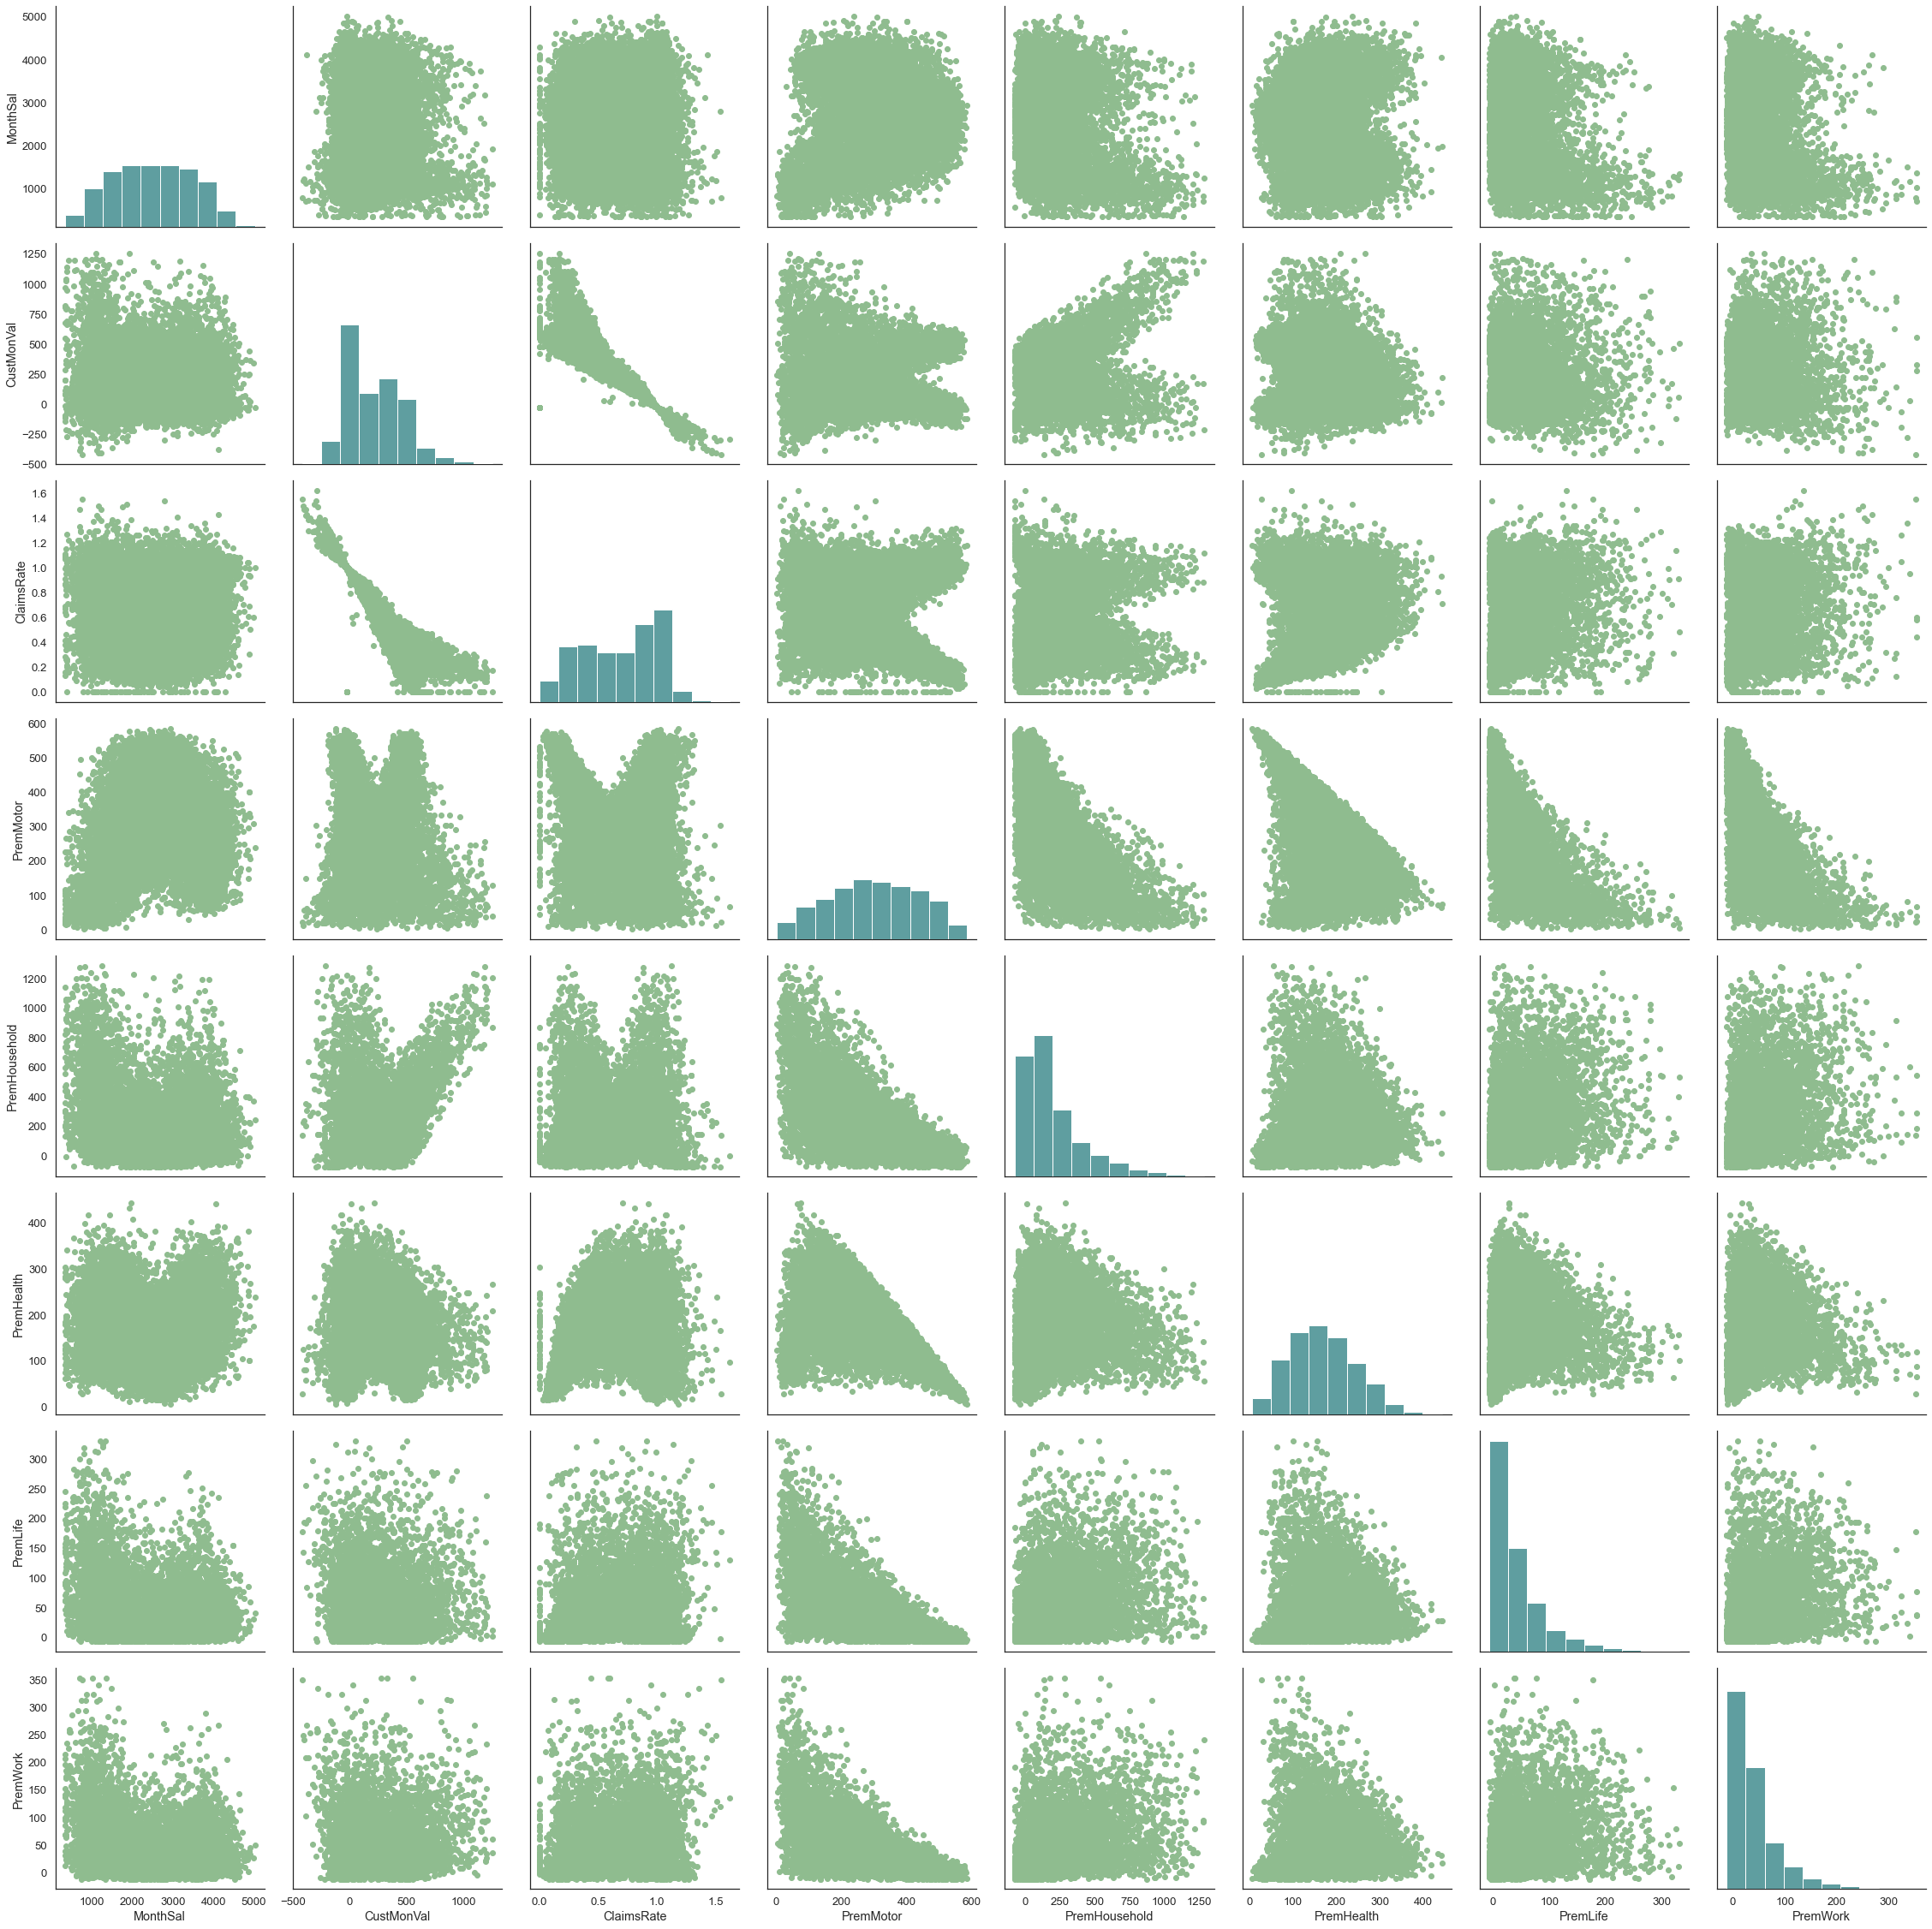

In [124]:
grid = sns.PairGrid(data= insur, vars = ['MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', \
                                         'PremLife', 'PremWork'], height = 4)
grid = grid.map_upper(plt.scatter, color = 'darkseagreen')
grid = grid.map_diag(plt.hist, bins = 10, color = 'cadetblue')
grid = grid.map_lower(plt.scatter, color = 'darkseagreen')

In [125]:
#DEFINE METRIC AND NON METRIC FEATURES
metric_features = insur.select_dtypes(include=np.number).set_index(insur.index).columns.to_list()
non_metric_features = insur.select_dtypes(exclude=np.number).set_index(insur.index).columns.to_list()

<a class="anchor" id="missing_values">

## 5. Treatment of Missing Values

</a>

In [126]:
insur.EducDeg = pd.to_numeric(insur.EducDeg)
insur.GeoLivArea = insur.GeoLivArea.astype('float64') 
insur.Children = insur.Children.astype('float64') 

insur.dtypes

CustID            string
FirstPolYear     float64
BirthYear        float64
EducDeg          float64
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [127]:
insur.isna().sum()

CustID              0
FirstPolYear       30
BirthYear        1964
EducDeg            17
MonthSal           36
GeoLivArea          1
Children           21
CustMonVal          0
ClaimsRate          0
PremMotor          33
PremHousehold       0
PremHealth         42
PremLife          104
PremWork           86
dtype: int64

In [128]:
#STRATEGIES TO APPLY

#FirstPolYear      30 ------> simply remove, it is probably an error of the system!

#GeoLivArea         1 -------> simply remove, it is only one observation!  --> replace with the mode????
                                #insur_ohc.loc[insur_ohc['status'] == 'Whatever', 'status'] = insur['status'].mode()[0]

#PremMotor         34 ------> replace with zero, meaning that they did not spent anything in that premium!
#PremHealth        43 ------> replace with zero, meaning that they did not spent anything in that premium!
#PremLife         104 ------> replace with zero, meaning that they did not spent anything in that premium!
#PremWork          86 ------> replace with zero, meaning that they did not spent anything in that premium!


#BirthYear         1970 (instead of initial 17) 
#EducDeg           17 
#MonthSal          36 
#Children          21 

### Remove missing values from FirstPolYear, GeoLivArea and Prem Variables

In [129]:
# Remove missing values from FirstPolYear
insur.dropna(subset=['FirstPolYear'], inplace=True)  # 30 rows dropped

# Remove missing values from GeoLivArea
insur.dropna(subset = ['GeoLivArea'], inplace = True) # 1 row dropped

# Remove missing values from Prem variables
insur['PremMotor'].fillna(0, inplace = True)
insur['PremHealth'].fillna(0, inplace = True)
insur['PremLife'].fillna(0, inplace = True)
insur['PremWork'].fillna(0, inplace = True)

In [130]:
insur.isna().sum()

CustID              0
FirstPolYear        0
BirthYear        1961
EducDeg             2
MonthSal           34
GeoLivArea          0
Children           13
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
dtype: int64

In [131]:
#EducDeg           2 ----->  nearest neighbours
#MonthSal          34 ----->  nearest neighbours
#Children          13 ----->  nearest neighbours

#BirthYear         1967 (instead of initial 17) ----->  nearest neighbours

### Remove missing values from EducDeg

In [132]:
# Use this regression to see which variables afect each variable
y,x = dmatrices('EducDeg ~ FirstPolYear + MonthSal + GeoLivArea + CustMonVal + ClaimsRate + PremMotor + PremHousehold + PremHealth + PremLife + PremWork', 
                data = insur, NA_action='drop', return_type='dataframe')
mod = sm.OLS(y,x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                EducDeg   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     425.3
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:12:56   Log-Likelihood:                -10251.
No. Observations:               10148   AIC:                         2.052e+04
Df Residuals:                   10137   BIC:                         2.060e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3498      1.991      1.180

In [133]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


# Impute the missing values in EducDeg
missing_EducDeg = insur.loc[insur.EducDeg.isnull()]
#missing_EducDeg
complete = insur.loc[~insur.EducDeg.isnull()]
#complete


# We can change these parameters !!!
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')


# Fit our model to X and y (without missing values)
knn_fitted = knn.fit(complete.loc[ : , ['PremMotor','PremHealth','PremHousehold','PremLife','PremWork']], complete.loc[ : , 'EducDeg'])

# Imput the missing values in EducDeg
imputed_values = knn_fitted.predict(missing_EducDeg.loc[ : , ['PremMotor','PremHealth','PremHousehold','PremLife','PremWork']])

missing_EducDeg = missing_EducDeg.drop(columns='EducDeg')
missing_EducDeg.insert(3, 'EducDeg', imputed_values)
imputed_EducDeg = missing_EducDeg
display(imputed_EducDeg) # Show imputed observations

# Drop the nulls values in EducDeg
insur.dropna(subset = ['EducDeg'], inplace = True) # 2 rows dropped

# Concate the observations that had nulls and were imputed
insur = insur.append(imputed_EducDeg) # 2 rows added

CustID  FirstPolYear  BirthYear  EducDeg  MonthSal  GeoLivArea  \
1707  1708.0        1992.0     1946.0      2.0    3827.0         4.0   
6560  6561.0        1976.0        NaN      1.0       NaN         4.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
1707       0.0      355.52        0.33     222.71          146.7         0.0   
6560       1.0       85.91        0.77      91.24            0.0       227.6   

      PremLife  PremWork  
1707     94.13    105.24  
6560     60.01    110.91

In [134]:
insur.isna().sum()

CustID              0
FirstPolYear        0
BirthYear        1961
EducDeg             0
MonthSal           34
GeoLivArea          0
Children           13
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
dtype: int64

### Remove missing values from MonthSal

In [135]:
# Impute the missing values in MonthSal

y,x = dmatrices('MonthSal ~ FirstPolYear + Children + GeoLivArea + EducDeg + CustMonVal + ClaimsRate + PremHealth + PremMotor + PremHousehold + PremLife + PremWork', data = insur, NA_action='drop', return_type='dataframe')
mod = sm.OLS(y,x)
res = mod.fit()
print(res.summary())
# dá 36% de variância explicada

                            OLS Regression Results                            
Dep. Variable:               MonthSal   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     508.1
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:12:57   Log-Likelihood:                -81982.
No. Observations:               10136   AIC:                         1.640e+05
Df Residuals:                   10124   BIC:                         1.641e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2991.8720   2362.889     -1.266

In [136]:
#criar tabela com as observacoes onde MonthSal é null
missing_MonthSal = insur[insur['MonthSal'].isna()]

#criar outra tabela com as observaçoes inversas
complete = insur[~insur.index.isin(missing_MonthSal.index)]
#retirar observaçoes onde children é null
complete = complete.loc[complete.Children.notnull()]


#criar o regressor - podemos alterar isto !!!
regressor = KNeighborsRegressor(10, weights='distance', metric='euclidean')


#treinar os dados
regressor_fitted = regressor.fit(complete.loc[:, ['FirstPolYear', 'Children', 'EducDeg', 'PremHousehold', 'PremMotor', 'PremLife', 'PremWork']], complete.loc[:,['MonthSal']])

#criar array com os valores previstos
imputed_values = regressor_fitted.predict(missing_MonthSal.loc[:, ['FirstPolYear', 'Children', 'EducDeg', 'PremHousehold', 'PremMotor', 'PremLife', 'PremWork']])

missing_MonthSal = missing_MonthSal.drop(columns=['MonthSal'])
missing_MonthSal.insert(4, 'MonthSal', imputed_values)
imputed_MonthSal = missing_MonthSal
display(imputed_MonthSal) # Show imputed observations

#remover do dataframe original todas as observaçoes onde MonthSal é null
insur = insur.loc[insur['MonthSal'].notnull()]

insur = pd.concat([insur, imputed_MonthSal])

CustID  FirstPolYear  BirthYear  EducDeg     MonthSal  GeoLivArea  \
21      22.0        1977.0     1958.0      2.0  3036.000000         3.0   
143    144.0        1996.0     1990.0      3.0   978.000000         4.0   
488    489.0        1977.0     1947.0      3.0  2404.227298         3.0   
539    540.0        1979.0        NaN      2.0  2298.896045         2.0   
830    831.0        1988.0     1942.0      2.0  2571.960883         4.0   
1160  1161.0        1981.0        NaN      3.0  2384.622436         3.0   
1780  1781.0        1998.0     1964.0      3.0  2547.684570         1.0   
1816  1817.0        1978.0     1959.0      3.0  2680.751171         2.0   
1851  1852.0        1976.0     1953.0      3.0  2710.000000         4.0   
1872  1873.0        1978.0     1963.0      2.0  2749.000000         2.0   
2241  2242.0        1988.0     1964.0      3.0  2917.000000         1.0   
3227  3228.0        1990.0     1949.0      4.0  3413.601025         1.0   
3317  3318.0        1980.0     1943.0      2.0  2827.764286         2.0   
3477  3478.0        1993.0     1939.0      1.0  3776.000000         3.0   
3720  3721.0        1976.0        NaN      3.0  2533.000000         4.0   
3972  3973.0        1988.0     1979.0      2.0  3219.188785         4.0   
4625  4626.0        1978.0        NaN      3.0  2497.456758         4.0   
4847  4848.0        1989.0     1987.0      3.0  1643.000000         1.0   
5082  5083.0        1986.0     1953.0      2.0  2453.675767         4.0   
5396  5397.0        1977.0        NaN      3.0  2943.005951         4.0   
5538  5539.0        1983.0        NaN      3.0  2678.685914         3.0   
5574  5575.0        1995.0     1972.0      3.0  2659.000000         3.0   
5850  5851.0        1989.0        NaN      1.0  1356.000000         3.0   
6461  6462.0        1976.0        NaN      3.0  2226.959383         4.0   
7371  7372.0        1977.0     1952.0      3.0  3422.000000         4.0   
7453  7454.0        1974.0     1944.0      1.0  3149.000000         1.0   
7892  7893.0        1986.0        NaN      3.0  2785.193097         2.0   
8676  8677.0        1979.0        NaN      1.0  2196.981895         4.0   
8677  8678.0        1988.0     1944.0      1.0  3237.088760         1.0   
9276  9277.0        1983.0     1947.0      3.0  3343.061905         4.0   
9821  9822.0        1978.0        NaN      3.0  2657.001919         3.0   
9904  9905.0        1984.0     1960.0      3.0  2975.000000         4.0   
9960  9961.0        1994.0     1989.0      2.0  3133.163195         1.0   
6560  6561.0        1976.0        NaN      1.0  2883.921927         4.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
21         1.0      111.37        0.80     407.52         111.70      100.13   
143        1.0      -42.45        1.02     146.36         353.95      220.04   
488        0.0      -52.56        1.09       0.00           0.00      278.83   
539        1.0       85.13        0.79     156.25           0.00      237.71   
830        0.0      475.43        0.00     274.83           0.00      180.59   
1160       1.0        4.56        0.79       0.00           0.00      106.02   
1780       1.0      454.43        0.16     509.43           0.00       66.90   
1816       1.0       58.68        0.62       0.00           0.00      138.47   
1851       1.0       14.45        0.95     366.29         300.60      134.36   
1872       1.0      -12.33        0.98     269.94         206.70      225.71   
2241       1.0      517.65        0.14     502.54          50.00       76.57   
3227       0.0        8.12        0.87     225.60           0.00        0.00   
3317       0.0      -38.56        1.02     363.29           0.00      154.14   
3477       0.0      150.81        0.74     175.81         108.35      261.27   
3720       1.0      487.20        0.23     437.86          79.45      142.47   
3972       1.0      207.60        0.51     252.27           0.00      134.58   
4625       1.0      

In [137]:
insur.isna().sum()

CustID              0
FirstPolYear        0
BirthYear        1961
EducDeg             0
MonthSal            0
GeoLivArea          0
Children           13
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
dtype: int64

### Remove missing values from Children

In [138]:
# Impute the missing values in Children

y,x = dmatrices('Children ~ FirstPolYear + EducDeg + MonthSal + GeoLivArea + CustMonVal + ClaimsRate + PremMotor + PremHousehold + PremHealth + PremLife + PremWork', 
                data = insur, NA_action='drop', return_type='dataframe')
mod = sm.OLS(y,x)
res = mod.fit()
print(res.summary())
# dá 36% de variância explicada

                            OLS Regression Results                            
Dep. Variable:               Children   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     503.2
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:12:58   Log-Likelihood:                -4209.6
No. Observations:               10170   AIC:                             8443.
Df Residuals:                   10158   BIC:                             8530.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7332      1.095      0.669

In [139]:
missing_Children = insur.loc[insur.Children.isnull()]
#missing_Children
complete = insur.loc[~insur.Children.isnull()]
#complete



# We can change these parameters - podemos mudar isto !!!
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')



# Fit our model to X and y (without missing values)
knn_fitted = knn.fit(complete.loc[ : , ['EducDeg', 'MonthSal', 'GeoLivArea', 'PremMotor','PremHealth','PremHousehold','PremLife','PremWork']], complete.loc[ : , 'Children'])

# Imput the missing values in EducDeg
imputed_values = knn_fitted.predict(missing_Children.loc[ : , ['EducDeg', 'MonthSal', 'GeoLivArea', 'PremMotor','PremHealth','PremHousehold','PremLife','PremWork']])

missing_Children = missing_Children.drop(columns='Children')
missing_Children.insert(6, 'Children', imputed_values)
imputed_Children = missing_Children
display(imputed_Children) # show imputed observations

#drop the nulls values in EducDeg
insur.dropna(subset = ['Children'], inplace = True) # 2 rows dropped

#concate the observations that had nulls and were imputed
insur = insur.append(imputed_Children) # 2 rows added

CustID  FirstPolYear  BirthYear  EducDeg  MonthSal  GeoLivArea  \
619    620.0        1980.0        NaN      3.0    1333.0         2.0   
772    773.0        1998.0     1949.0      2.0    3601.0         2.0   
2362  2363.0        1981.0     1975.0      2.0    1607.0         2.0   
2671  2672.0        1992.0     1988.0      2.0    1140.0         2.0   
3177  3178.0        1980.0     1975.0      3.0    2647.0         2.0   
3280  3281.0        1980.0     1949.0      2.0    3509.0         2.0   
3684  3685.0        1992.0     1959.0      1.0    3086.0         2.0   
4728  4729.0        1979.0     1964.0      1.0    2740.0         2.0   
5437  5438.0        1976.0        NaN      3.0    1817.0         2.0   
6471  6472.0        1988.0     1952.0      2.0    3228.0         2.0   
8018  8019.0        1982.0     1963.0      3.0    2699.0         2.0   
8374  8375.0        1993.0        NaN      1.0     924.0         2.0   
8419  8420.0        1976.0     1966.0      3.0    2884.0         2.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
619        1.0      312.52        0.40     286.83          -6.10      175.70   
772        0.0       27.01        0.94     104.91         308.95      285.61   
2362       1.0      271.51        0.64     292.61         308.40      159.14   
2671       1.0      356.40        0.54     168.03         265.60      273.94   
3177       1.0      392.19        0.37     404.41         107.25      110.80   
3280       0.0      253.61        0.59     170.70         161.15      229.60   
3684       0.0      -92.68        1.09     367.07         147.80      124.80   
4728       1.0      -27.89        1.00     480.20          88.35       83.35   
5437       1.0      -37.00        1.02     372.85         186.70      146.25   
6471       0.0      294.95        0.62     319.95         328.95      131.47   
8018       1.0      434.66        0.16     509.54         -25.55       72.68   
8374       1.0     -245.93        1.20      58.01         612.90      190.48   
8419       1.0      533.10        0.08     529.10          25.00       50.01   

      PremLife  PremWork  
619      52.90     56.79  
772      64.90     52.90  
2362     11.89     59.68  
2671     68.79     52.23  
3177     24.56     12.78  
3280      5.78    113.69  
3684      9.78     67.68  
4728      5.89      2.89  
5437     13.78      1.78  
6471     62.90      6.78  
8018     -1.11     -7.00  
8374     45.23    175.70  
8419     -1.00      5.00

In [140]:
insur.isna().sum()

CustID              0
FirstPolYear        0
BirthYear        1961
EducDeg             0
MonthSal            0
GeoLivArea          0
Children            0
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
dtype: int64

### Remove missing values from BirthYear

In [141]:
# Impute the missing values in BirthYear

y,x = dmatrices('BirthYear ~ FirstPolYear + EducDeg + MonthSal + GeoLivArea + Children + CustMonVal + ClaimsRate + PremMotor + PremHousehold + PremHealth + PremLife + PremWork', 
                data = insur, NA_action='drop', return_type='dataframe')
mod = sm.OLS(y,x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              BirthYear   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     3372.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:12:59   Log-Likelihood:                -26426.
No. Observations:                8222   AIC:                         5.288e+04
Df Residuals:                    8209   BIC:                         5.297e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1774.3722     20.837     85.156

In [142]:
missing_BirthYear = insur.loc[insur.BirthYear.isnull()]
#missing_BirthYear
complete = insur.loc[~insur.BirthYear.isnull()]
#complete



# We can change these parameters
clf = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')



# Fit our model to X and y (without missing values)
trained_model = clf.fit(complete.loc[ : , ['FirstPolYear','MonthSal', 'Children']], complete.loc[ : , 'BirthYear'])

# Imput the missing values in EducDeg
imputed_values = trained_model.predict(missing_BirthYear.loc[ : , ['FirstPolYear','MonthSal', 'Children']])

missing_BirthYear = missing_BirthYear.drop(columns='BirthYear')
missing_BirthYear.insert(2, 'BirthYear', imputed_values)
imputed_BirthYear = missing_BirthYear
display(imputed_BirthYear) # show imputed observations

#drop the nulls values in EducDeg
insur.dropna(subset = ['BirthYear'], inplace = True) # 1967 rows dropped

#concate the observations that had nulls and were imputed
insur = insur.append(imputed_BirthYear, sort=True) 

CustID  FirstPolYear  BirthYear  EducDeg     MonthSal  GeoLivArea  \
1        2.0        1981.0     1990.0      2.0   677.000000         4.0   
13      14.0        1983.0     1985.0      1.0  1043.000000         3.0   
18      19.0        1981.0     1979.0      1.0  1414.000000         3.0   
22      23.0        1976.0     1977.0      2.0  1495.000000         1.0   
40      41.0        1994.0     1990.0      2.0  1177.000000         4.0   
...      ...           ...        ...      ...          ...         ...   
9821  9822.0        1978.0     1960.0      3.0  2657.001919         3.0   
6560  6561.0        1976.0     1966.0      1.0  2883.921927         4.0   
619    620.0        1980.0     1982.0      3.0  1333.000000         2.0   
5437  5438.0        1976.0     1973.0      3.0  1817.000000         2.0   
8374  8375.0        1993.0     1993.0      1.0   924.000000         2.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
1          1.0     -131.13        1.12      77.46         416.20      116.69   
13         1.0      -75.12        1.06      44.34         342.85      127.69   
18         1.0      230.38        0.71     313.17         373.40      121.80   
22         1.0      -89.79        1.08     209.04         308.95      192.48   
40         1.0      121.36        0.84      52.01         455.65      135.47   
...        ...         ...         ...        ...            ...         ...   
9821       1.0      289.39        0.47     339.84           0.00      175.81   
6560       1.0       85.91        0.77      91.24           0.00      227.60   
619        1.0      312.52        0.40     286.83          -6.10      175.70   
5437       1.0      -37.00        1.02     372.85         186.70      146.25   
8374       1.0     -245.93        1.20      58.01         612.90      190.48   

      PremLife  PremWork  
1       194.48    106.13  
13      267.94     94.46  
18       14.78     72.57  
22       64.79     54.90  
40      146.36    148.03  
...        ...       ...  
9821     51.12     25.45  
6560     60.01    110.91  
619      52.90     56.79  
5437     13.78      1.78  
8374     45.23    175.70  

[1961 rows x 14 columns]

In [143]:
insur.apply(lambda x: 1 if x.FirstPolYear < x.BirthYear else 0, axis=1).value_counts()

0    9408
1     775
dtype: int64

In [144]:
insur.isna().sum()

BirthYear        0
Children         0
ClaimsRate       0
CustID           0
CustMonVal       0
EducDeg          0
FirstPolYear     0
GeoLivArea       0
MonthSal         0
PremHealth       0
PremHousehold    0
PremLife         0
PremMotor        0
PremWork         0
dtype: int64

In [145]:
#REMOVE BirthYear FROM THE DATASET
insur.drop('BirthYear', axis = 1, inplace= True)

In [146]:
#REMOVE CustID FROM THE DATASET
insur.drop('CustID', axis = 1, inplace= True)

In [147]:
insur.head()

Children  ClaimsRate  CustMonVal  EducDeg  FirstPolYear  GeoLivArea  \
0       1.0        0.39      380.97      2.0        1985.0         1.0   
2       0.0        0.28      504.67      1.0        1991.0         3.0   
3       1.0        0.99      -16.99      3.0        1990.0         4.0   
4       1.0        0.90       35.23      3.0        1986.0         4.0   
5       1.0        1.00      -24.33      2.0        1986.0         4.0   

   MonthSal  PremHealth  PremHousehold  PremLife  PremMotor  PremWork  
0    2177.0      146.36          79.45     47.01     375.85     16.89  
2    2277.0      124.58         224.50     86.35     206.15     99.02  
3    1099.0      311.17          43.35     35.34     182.48     28.34  
4    1763.0      182.59          47.80     18.78     338.62     41.45  
5    2566.0      114.80          18.90      7.00     440.75      7.67

<a class="anchor" id="feature_engineering">

## 6. Feature Engineering

</a>

In [59]:
# Usar isto para pormos as colunas novas num sítio que dê jeito para visualizar (opcional)

#insur.insert(indice, nome_coluna, valores)  

In [60]:
#Number of year since the client has been involved with the company
#insur.insert(5, 'Client_Recency', 2016 - insur['FirstPolYear'])

In [151]:
insur['Client_Recency'] = 2016 - insur['FirstPolYear']

#Total amount spent in premiums 
insur['Total_Premiums'] = insur.loc[:,['PremMotor','PremHousehold','PremHealth','PremLife','PremWork']].sum(1)
 
#Annual Salary of the client
insur['Annual_Salary'] = 12 * insur['MonthSal']

#Weight of the expenditure in Premiums on the total Annual Salary
insur['Salary_Ratio'] = insur['Total_Premiums']/insur['Annual_Salary']

#Weight of the expenditure in Motor Premiums on the Total Premiums 
insur['PremMotor_Ratio'] = insur['PremMotor']/insur['Total_Premiums']
insur['PremMotor_Ratio'] = insur['PremMotor_Ratio'].where(insur['PremMotor_Ratio']>0, 0)

#Weight of the expenditure in Household Premiums on the Total Premiums 
insur['PremHousehold_Ratio'] = insur['PremHousehold']/insur['Total_Premiums']
insur['PremHousehold_Ratio'] = insur['PremHousehold_Ratio'].where(insur['PremHousehold_Ratio']>0, 0)

#Weight of the expenditure in Health Premiums on the Total Premiums 
insur['PremHealth_Ratio'] = insur['PremHealth']/insur['Total_Premiums']
insur['PremHealth_Ratio'] = insur['PremHealth_Ratio'].where(insur['PremHealth_Ratio']>0, 0)

#Weight of the expenditure in Life Premiums on the Total Premiums 
insur['PremLife_Ratio'] = insur['PremLife']/insur['Total_Premiums']
insur['PremLife_Ratio'] = insur['PremLife_Ratio'].where(insur['PremLife_Ratio']>0, 0)

#Weight of the expenditure in Work Premiums on the Total Premiums 
insur['PremWork_Ratio'] = insur['PremWork']/insur['Total_Premiums']
insur['PremWork_Ratio'] = insur['PremWork_Ratio'].where(insur['PremWork_Ratio']>0, 0)


#Sum of the cancelled premiums
insur['Cancelled_Premiums'] = insur.iloc[:,7:11].sum(1)

#Takes the value 1 if the customer cancelled any premium, 0 otherwise
insur['Cancelled_binary'] = np.where(insur['Cancelled_Premiums'] < 0, 1, 0) # --> dá tudo 0's



#Apply Square Root to some variables because of Skewness
# SQRT's from original variables with long tails
insur['PremLife_sqrt'] = np.sqrt(insur['PremLife'] + abs(insur['PremLife'].min()))
insur['PremWork_sqrt'] = np.sqrt(insur['PremWork'] + abs(insur['PremWork'].min()))
insur['PremHousehold_sqrt'] = np.sqrt(insur['PremHousehold'] + abs(insur['PremHousehold'].min()))

#As we had negative numbers and it is not possible to compute the square root of a negative number,
#we had to sum to all observations the absolute value of the minimum value for each variable. 


# SQRT's from new variables with long tails
insur['Salary_Ratio_sqrt'] = np.sqrt(insur['Salary_Ratio'])
insur['PremLife_Ratio_sqrt'] = np.sqrt(insur['PremLife_Ratio'])
insur['PremWork_Ratio_sqrt'] = np.sqrt(insur['PremWork_Ratio']) 
insur['PremHousehold_Ratio_sqrt'] = np.sqrt(insur['PremHousehold_Ratio'])


In [152]:
#Checking the sqrt variables histograms

Sqrt of original variables

In [153]:
fig = px.histogram(insur, x=insur.PremLife_sqrt, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

In [154]:
fig = px.histogram(insur, x=insur.PremWork_sqrt, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

In [155]:
fig = px.histogram(insur, x=insur.PremHousehold_sqrt, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

Sqrt of new variables

In [156]:
fig = px.histogram(insur, x=insur.Salary_Ratio_sqrt, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

In [157]:
fig = px.histogram(insur, x=insur.PremLife_Ratio, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

In [158]:
fig = px.histogram(insur, x=insur.PremWork_Ratio_sqrt, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

In [159]:
fig = px.histogram(insur, x=insur.PremHousehold_Ratio_sqrt, color_discrete_sequence=['darkseagreen'], template='plotly_white',  \
                   width=950, height=400)
fig.show()

In [160]:
insur.EducDeg = insur.GeoLivArea.astype('string')
insur.GeoLivArea = insur.GeoLivArea.astype('string') 
insur.Children = insur.Children.astype('string') 
#insur.FirstPolYear = insur.FirstPolYear.astype('string') 


metric_features = insur.select_dtypes(include=np.number).set_index(insur.index).columns.to_list()
non_metric_features = insur.select_dtypes(exclude=np.number).set_index(insur.index).columns.to_list()

In [161]:
insur[metric_features].describe().round(2).T

count      mean       std      min       25%  \
ClaimsRate                10183.0      0.68      0.32     0.00      0.39   
CustMonVal                10183.0    215.58    250.66  -416.73     -9.10   
FirstPolYear              10183.0   1986.02      6.61  1974.00   1980.00   
MonthSal                  10183.0   2504.93    980.39   333.00   1717.00   
PremHealth                10183.0    167.63     74.71     0.00    111.80   
PremHousehold             10183.0    202.01    222.89   -75.00     49.45   
PremLife                  10183.0     41.08     46.58    -7.00      9.78   
PremMotor                 10183.0    297.08    138.06     0.00    191.37   
PremWork                  10183.0     40.41     46.21   -12.00      9.89   
Client_Recency            10183.0     29.98      6.61    18.00     24.00   
Total_Premiums            10183.0    748.20    184.19     0.00    626.12   
Annual_Salary             10183.0  30059.13  11764.67  3996.00  20604.00   
Salary_Ratio              10183.0      0.03      0.03     0.00      0.02   
PremMotor_Ratio           10183.0      0.44      0.25     0.00      0.24   
PremHousehold_Ratio       10183.0      0.23      0.19     0.00      0.08   
PremHealth_Ratio          10183.0      0.23      0.11     0.00      0.15   
PremLife_Ratio            10183.0      0.05      0.06     0.00      0.01   
PremWork_Ratio            10183.0      0.05      0.06     0.00      0.01   
Cancelled_Premiums        10183.0    707.80    170.13     0.00    599.95   
Cancelled_binary          10183.0      0.00      0.00     0.00      0.00   
PremLife_sqrt             10183.0      6.26      2.99     0.00      4.10   
PremWork_sqrt             10183.0      6.66      2.83     0.00      4.68   
PremHousehold_sqrt        10183.0     15.45      6.18     0.00     11.16   
Salary_Ratio_sqrt         10183.0      0.17      0.06     0.00      0.13   
PremLife_Ratio_sqrt       10183.0      0.20      0.12     0.00      0.12   
PremWork_Ratio_sqrt       10183.0      0.20      0.12     0.00      0.12   
PremHousehold_Ratio_sqrt  10183.0      0.42      0.23     0.00      0.28   

                               50%       75%       max  
ClaimsRate                    0.72      0.98      1.62  
CustMonVal                  186.71    397.92   1254.46  
FirstPolYear               1986.00   1992.00   1998.00  
MonthSal                   2509.00   3292.00   5021.00  
PremHealth                  162.81    219.04    442.86  
PremHousehold               132.25    285.60   1286.90  
PremLife                     24.67     56.90    330.84  
PremMotor                   298.61    407.52    585.22  
PremWork                     25.56     55.90    353.18  
Client_Recency               30.00     36.00     42.00  
Total_Premiums              696.80    821.92   1633.52  
Annual_Salary             30108.00  39504.00  60252.00  
Salary_Ratio                  0.02      0.04      0.37  
PremMotor_Ratio               0.42      0.63      1.12  
PremHousehold_Ratio           0.19      0.35      0.87  
PremHealth_Ratio              0.22      0.30      0.97  
PremLife_Ratio                0.03      0.07      0.48  
PremWork_Ratio                0.04      0.07      0.51  
Cancelled_Premiums          667.11    771.96   1543.17  
Cancelled_binary              0.00      0.00      0.00  
PremLife_sqrt                 5.63      7.99     18.38  
PremWork_sqrt                 6.13      8.24     19.11  
PremHousehold_sqrt           14.40     18.99     36.90  
Salary_Ratio_sqrt             0.15      0.19      0.60  
PremLife_Ratio_sqrt           0.19      0.27      0.70  
PremWork_Ratio_sqrt           0.19      0.27      0.71  
PremHousehold_Ratio_sqrt      0.44      0.59      0.93

In [162]:
# SCALE THE METRIC FEATURES  --> try with the four different types of scalers (function??)  !!!!!!!!!!!!!!

# Select the scaler to use
scaler = MinMaxScaler()

scaled_feat = scaler.fit_transform(insur[metric_features])
insur[metric_features] = scaled_feat

# Checking max and min of minmaxed variables
insur[metric_features].describe().round(2).T

count  mean   std  min   25%   50%   75%  max
ClaimsRate                10183.0  0.42  0.20  0.0  0.24  0.44  0.60  1.0
CustMonVal                10183.0  0.38  0.15  0.0  0.24  0.36  0.49  1.0
FirstPolYear              10183.0  0.50  0.28  0.0  0.25  0.50  0.75  1.0
MonthSal                  10183.0  0.46  0.21  0.0  0.30  0.46  0.63  1.0
PremHealth                10183.0  0.38  0.17  0.0  0.25  0.37  0.49  1.0
PremHousehold             10183.0  0.20  0.16  0.0  0.09  0.15  0.26  1.0
PremLife                  10183.0  0.14  0.14  0.0  0.05  0.09  0.19  1.0
PremMotor                 10183.0  0.51  0.24  0.0  0.33  0.51  0.70  1.0
PremWork                  10183.0  0.14  0.13  0.0  0.06  0.10  0.19  1.0
Client_Recency            10183.0  0.50  0.28  0.0  0.25  0.50  0.75  1.0
Total_Premiums            10183.0  0.46  0.11  0.0  0.38  0.43  0.50  1.0
Annual_Salary             10183.0  0.46  0.21  0.0  0.30  0.46  0.63  1.0
Salary_Ratio              10183.0  0.09  0.08  0.0  0.05  0.06  0.10  1.0
PremMotor_Ratio           10183.0  0.39  0.22  0.0  0.21  0.38  0.56  1.0
PremHousehold_Ratio       10183.0  0.26  0.22  0.0  0.09  0.22  0.40  1.0
PremHealth_Ratio          10183.0  0.24  0.11  0.0  0.15  0.22  0.31  1.0
PremLife_Ratio            10183.0  0.11  0.12  0.0  0.03  0.07  0.15  1.0
PremWork_Ratio            10183.0  0.10  0.11  0.0  0.03  0.07  0.14  1.0
Cancelled_Premiums        10183.0  0.46  0.11  0.0  0.39  0.43  0.50  1.0
Cancelled_binary          10183.0  0.00  0.00  0.0  0.00  0.00  0.00  0.0
PremLife_sqrt             10183.0  0.34  0.16  0.0  0.22  0.31  0.43  1.0
PremWork_sqrt             10183.0  0.35  0.15  0.0  0.24  0.32  0.43  1.0
PremHousehold_sqrt        10183.0  0.42  0.17  0.0  0.30  0.39  0.51  1.0
Salary_Ratio_sqrt         10183.0  0.28  0.10  0.0  0.22  0.25  0.31  1.0
PremLife_Ratio_sqrt       10183.0  0.28  0.17  0.0  0.17  0.27  0.39  1.0
PremWork_Ratio_sqrt       10183.0  0.27  0.16  0.0  0.17  0.26  0.37  1.0
PremHousehold_Ratio_sqrt  10183.0  0.45  0.24  0.0  0.30  0.47  0.64  1.0

In [163]:
# EducDeg, Children e GeoLivArea --> criar dummies !!!!!!!!!!!!!!!!!!!!!!!

# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
encoder = OneHotEncoder(sparse=False, drop="first")

encoder_feat = encoder.fit_transform(insur[non_metric_features])
encoder_feat_names = encoder.get_feature_names()

encoder_insur = pd.DataFrame(encoder_feat, index=insur.index, columns=encoder_feat_names)  # Why the index=insur_encoder.index?
encoder_insur


# Reassigning insur to contain encoder variables
insur = pd.concat([insur.drop(columns=non_metric_features), encoder_insur], axis=1)
insur.head()

ClaimsRate  CustMonVal  FirstPolYear  MonthSal  PremHealth  PremHousehold  \
0    0.240741    0.477325      0.458333  0.393345    0.330488       0.113408   
2    0.172840    0.551344      0.708333  0.414676    0.281308       0.219913   
3    0.611111    0.239195      0.666667  0.163396    0.702637       0.086901   
4    0.555556    0.270442      0.500000  0.305034    0.412297       0.090168   
5    0.617284    0.234803      0.500000  0.476323    0.259224       0.068948   

   PremLife  PremMotor  PremWork  Client_Recency  ...  PremLife_Ratio_sqrt  \
0  0.159869   0.642237  0.079112        0.541667  ...             0.382004   
2  0.276314   0.352261  0.304014        0.291667  ...             0.490801   
3  0.125326   0.311814  0.110466        0.333333  ...             0.348641   
4  0.076308   0.578620  0.146366        0.500000  ...             0.248317   
5  0.041440   0.753136  0.053864        0.500000  ...             0.156680   

   PremWork_Ratio_sqrt  PremHousehold_Ratio_sqrt  x0_1.0  x1_2.0  x1_3.0  \
0             0.223014                  0.370035     1.0     0.0     0.0   
2             0.511894                  0.589666     0.0     0.0     1.0   
3             0.304081                  0.287715     1.0     0.0     0.0   
4             0.359306                  0.295186     1.0     0.0     0.0   
5             0.159737                  0.191831     1.0     0.0     0.0   

   x1_4.0  x2_2.0  x2_3.0  x2_4.0  
0     0.0     0.0     0.0     0.0  
2     0.0     0.0     1.0     0.0  
3     1.0     0.0     0.0     1.0  
4     1.0     0.0     0.0     1.0  
5     1.0     0.0     0.0     1.0  

[5 rows x 34 columns]

Correlations

<a class="anchor" id="feature_selection">

## 7. Feature Selection
</a>

In [164]:
correlacoes = insur[metric_features].corr(method='spearman')
correlacoes[np.abs(correlacoes)<0.05] = 0
correlacoes = round(correlacoes,1)

<ipython-input-165-c953b797a02f>:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-165-c953b797a02f>:17: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



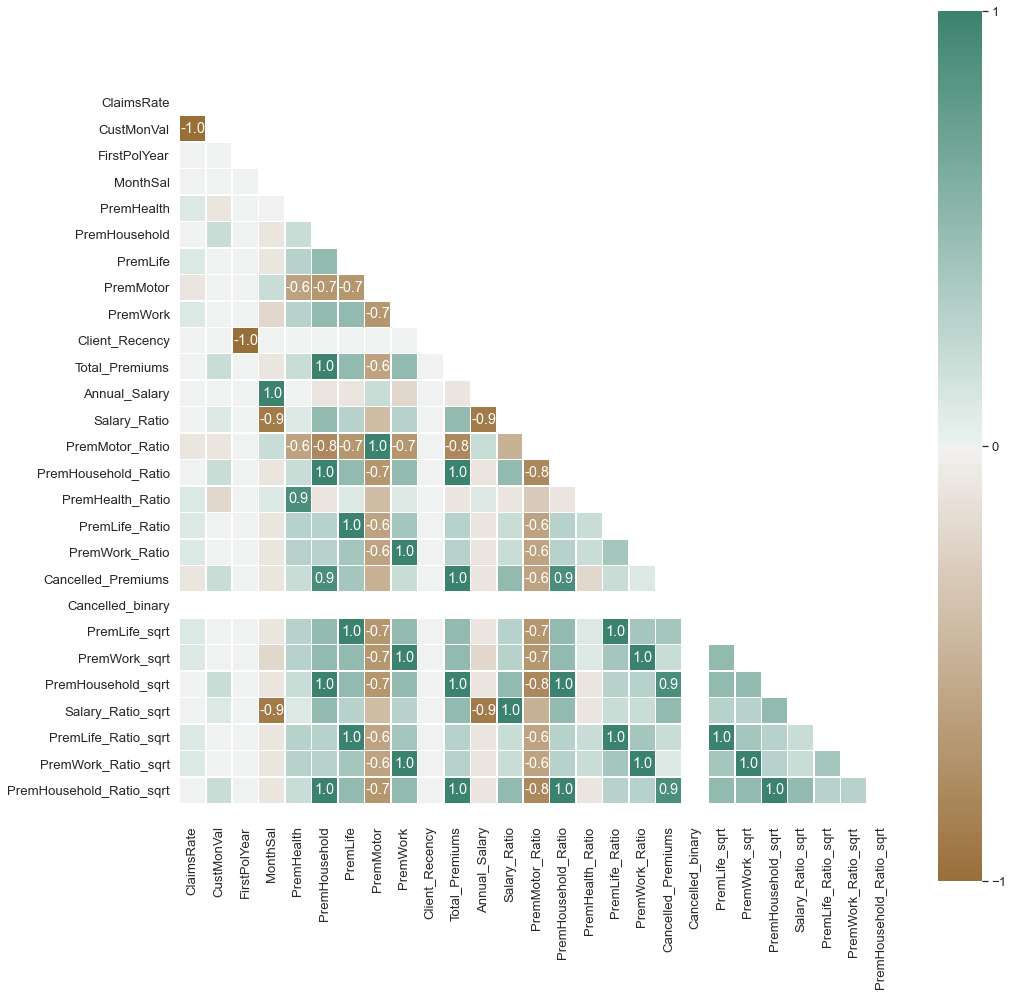

In [165]:
f, ax = plt.subplots(figsize = (16, 16))
mask = np.zeros_like(correlacoes, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

mask_annot = np.absolute(correlacoes.values) >= 0.6
annot1 = np.where(mask_annot, correlacoes.values, np.full((27,27),""))
cmap = sns.diverging_palette(49, 163, as_cmap = True)

sns.heatmap(correlacoes, mask=mask, cmap=cmap, center = 0, square = True, ax = ax, \
            linewidths = .5, annot = annot1, fmt = "s", vmin = -1, vmax = 1, cbar_kws= dict(ticks = [-1,0,1]))

sns.set(font_scale = 1.2)
sns.set_style('white')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [166]:
# Use this cell to drop the unwanted variables
#insur.drop(, axis=1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

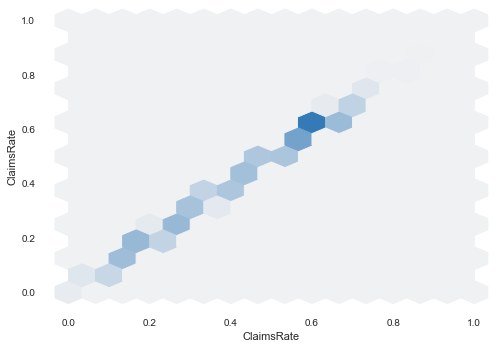

In [167]:
from pandas_profiling import ProfileReport

profile = ProfileReport(
    insur, 
    title='Insurance Dataset',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
)

profile.to_notebook_iframe()

<a class="anchor" id="pca">

## 8. PCA
</a>

In [168]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(insur[metric_features])
#pca_feat  # What is this output?

In [169]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue    Difference    Proportion  Cumulative
1   3.131935e-01  0.000000e+00  3.855031e-01    0.385503
2   1.516236e-01 -1.615699e-01  1.866302e-01    0.572133
3   9.410398e-02 -5.751959e-02  1.158306e-01    0.687964
4   8.890255e-02 -5.201427e-03  1.094282e-01    0.797392
5   5.387591e-02 -3.502664e-02  6.631470e-02    0.863707
6   4.637537e-02 -7.500543e-03  5.708244e-02    0.920789
7   4.300483e-02 -3.370532e-03  5.293372e-02    0.973723
8   7.794103e-03 -3.521073e-02  9.593594e-03    0.983317
9   4.129614e-03 -3.664489e-03  5.083053e-03    0.988400
10  2.664626e-03 -1.464988e-03  3.279830e-03    0.991679
11  1.660805e-03 -1.003821e-03  2.044249e-03    0.993724
12  1.446404e-03 -2.144010e-04  1.780347e-03    0.995504
13  9.940402e-04 -4.523637e-04  1.223543e-03    0.996728
14  7.101711e-04 -2.838691e-04  8.741344e-04    0.997602
15  5.469810e-04 -1.631902e-04  6.732671e-04    0.998275
16  4.375424e-04 -1.094386e-04  5.385615e-04    0.998814
17  3.710655e-04 -6.647684e-05  4.567366e-04    0.999270
18  3.159037e-04 -5.516186e-05  3.888390e-04    0.999659
19  1.110832e-04 -2.048204e-04  1.367300e-04    0.999796
20  7.244015e-05 -3.864309e-05  8.916502e-05    0.999885
21  6.228495e-05 -1.015520e-05  7.666520e-05    0.999962
22  3.115456e-05 -3.113039e-05  3.834747e-05    1.000000
23  7.559686e-30 -3.115456e-05  9.305055e-30    1.000000
24  4.051597e-33 -7.555635e-30  4.987023e-33    1.000000
25  1.483824e-33 -2.567773e-33  1.826407e-33    1.000000
26  1.465363e-33 -1.846162e-35  1.803683e-33    1.000000
27  1.314078e-33 -1.512844e-34  1.617470e-33    1.000000

<ipython-input-170-328e7334b54d>:22: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



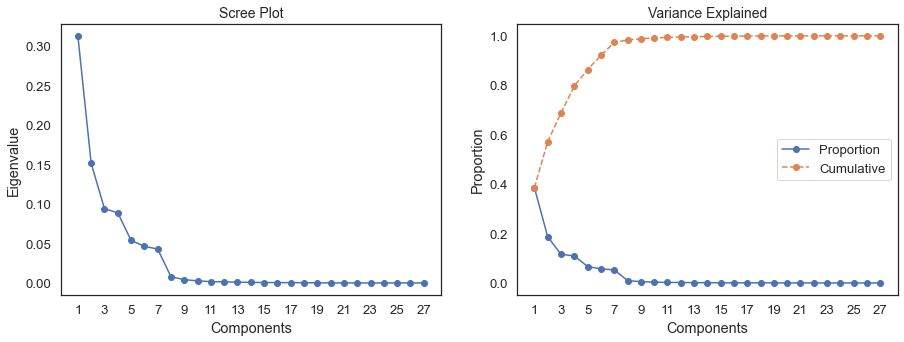

In [170]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [171]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(insur[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_insur = pd.DataFrame(pca_feat, index=insur.index, columns=pca_feat_names)  # remember index=insur_pca.index
pca_insur

PC0       PC1       PC2       PC3       PC4
0    -0.214940  0.060622  0.002027 -0.157871  0.220450
2     0.438918 -0.290015  0.119044 -0.060665  0.452755
3     0.043296 -0.215498  0.513774 -0.305295 -0.263328
4    -0.233263  0.010241  0.252468 -0.235177 -0.128606
5    -0.642227 -0.002481  0.063255 -0.095482 -0.207442
...        ...       ...       ...       ...       ...
9821 -0.429999  0.462034  0.333425 -0.020099  0.295716
6560  0.038457  0.577220  0.925998  0.202945  0.305184
619  -0.220361  0.365357  0.484904 -0.400246  0.345704
5437 -0.149539  0.602524 -0.154023 -0.165727 -0.376589
8374  1.093474 -0.370295  0.129968 -0.315367 -0.423367

[10183 rows x 5 columns]

In [172]:
# Reassigning insur to contain pca variables
insur_pca = pd.concat([insur, pca_insur], axis=1)
insur_pca.head()

ClaimsRate  CustMonVal  FirstPolYear  MonthSal  PremHealth  PremHousehold  \
0    0.240741    0.477325      0.458333  0.393345    0.330488       0.113408   
2    0.172840    0.551344      0.708333  0.414676    0.281308       0.219913   
3    0.611111    0.239195      0.666667  0.163396    0.702637       0.086901   
4    0.555556    0.270442      0.500000  0.305034    0.412297       0.090168   
5    0.617284    0.234803      0.500000  0.476323    0.259224       0.068948   

   PremLife  PremMotor  PremWork  Client_Recency  ...  x1_3.0  x1_4.0  x2_2.0  \
0  0.159869   0.642237  0.079112        0.541667  ...     0.0     0.0     0.0   
2  0.276314   0.352261  0.304014        0.291667  ...     1.0     0.0     0.0   
3  0.125326   0.311814  0.110466        0.333333  ...     0.0     1.0     0.0   
4  0.076308   0.578620  0.146366        0.500000  ...     0.0     1.0     0.0   
5  0.041440   0.753136  0.053864        0.500000  ...     0.0     1.0     0.0   

   x2_3.0  x2_4.0       PC0       PC1       PC2       PC3       PC4  
0     0.0     0.0 -0.214940  0.060622  0.002027 -0.157871  0.220450  
2     1.0     0.0  0.438918 -0.290015  0.119044 -0.060665  0.452755  
3     0.0     1.0  0.043296 -0.215498  0.513774 -0.305295 -0.263328  
4     0.0     1.0 -0.233263  0.010241  0.252468 -0.235177 -0.128606  
5     0.0     1.0 -0.642227 -0.002481  0.063255 -0.095482 -0.207442  

[5 rows x 39 columns]

In [173]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = insur_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

In [174]:
# Do this after checking the new pandas profiling report
#insur.drop(columns=['PC3'], inplace=True)

In [175]:
# Splitting feature names into groups
non_metric_features = insur.columns[insur.columns.str.startswith('x')]
pc_features = insur.columns[insur.columns.str.startswith('PC')]
metric_features = insur.columns[~insur.columns.str.startswith('x') & ~insur.columns.str.startswith('PC')]

In [ ]:
# SEGMENT VARIABLES BETWEE VALUE, PRODUCT, AND SOCIODEMOGRAPHIC

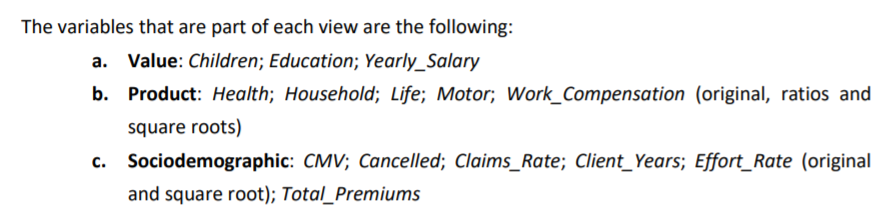

<a class="anchor" id="clustering_algorithms">

## 9. Clustering Algorithms
</a>

In [ ]:
## =============================================================================
#
#kproto = df_insurance[['Cust_ID','Yearly_Salary', 'Education', 'Children']]
#kproto.reset_index(drop=True, inplace=True)
#
#kp = KP(n_clusters=15, init='Huang', verbose=2)
#clusters = kp.fit_predict(kproto[['Yearly_Salary','Education','Children']], categorical=[1,2])
#
#centro = kp.cluster_centroids_
#kproto['Label'] = kp.labels_
#kproto.Label = kproto.Label.apply(pd.to_numeric)
#
#centroids = pd.DataFrame()
#centroids['Yearly_Salary']=pd.DataFrame(centro[0]).loc[:,0]
#centroids['Education']=pd.DataFrame(centro[1]).loc[:,0]
#centroids['Children']=pd.DataFrame(centro[1]).loc[:,1]
#
#del centro, kp, clusters
#
#Z = linkage(centroids, method = "ward")
#
#hierarchy.set_link_color_palette(['darkseagreen','cadetblue', 'seagreen', 'mediumseagreen', 'c','mediumturquoise','turquoise'])
#
#fig = plt.figure(figsize=(10, 20))
#ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
#Z = hierarchy.linkage(centroids, method='ward')
#
#dendrogram(Z,
#           truncate_mode="lastp",
#           p=40,
#           orientation ="top" ,
#           leaf_rotation=45.,
#           leaf_font_size=10.,
#           show_contracted=True,
#           show_leaf_counts=True)
#cur_axes = plt.gca()
#plt.xlabel('Cluster Size')
#plt.ylabel('Distance')
#
#ax2.set_yticks([])
#ax2.axis('off')
#
#Hclustering = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
#HC = Hclustering.fit(centroids)
##HC = Hclustering.fit(kproto[['Yearly_Salary','Education','Children']])
#
#labels = pd.DataFrame(HC.labels_)
#labels.columns =  ['Socio-Demo']
#
#
#centroids = pd.concat([centroids, labels], axis = 1)
#centroids['Label']=[i for i in range(0,15)]
#
#j=0
#for i in range(0, len(centroids['Socio-Demo'])):
#    kproto['Label']=kproto['Label'].replace(centroids['Label'][i], centroids['Socio-Demo'][j])
#    j+=1
#
#df_insurance_socio = pd.concat([df_insurance, kproto['Label']], axis=1)
#df_insurance_socio.rename(columns={"Label": "Socio-Demo"}, inplace=True)
#
#del Z, fig, ax2, centroids, cur_axes, Hclustering, labels, kproto
#
#fig, axs = plt.subplots(3, 3, figsize=(15,15))
#
## cluster 0
#axs[0, 0].hist(df_insurance_socio['Yearly_Salary'].loc[df_insurance_socio['Socio-Demo']==0], color='darkseagreen', range=[5000, 60000])
#axs[0, 0].set_title('Salary for Cluster 1')
#axs[0, 1].hist(df_insurance_socio['Education'].loc[df_insurance_socio['Socio-Demo']==0], color='cadetblue', range=[1,4])
#axs[0, 1].set_title('Education for Cluster 1')
#plt.sca(axs[0, 1])
#plt.xticks([1, 2, 3, 4])
#axs[0, 2].hist(df_insurance_socio['Children'].loc[df_insurance_socio['Socio-Demo']==0], color='tan')
#axs[0, 2].set_title('Children for Cluster 1')
#plt.sca(axs[0, 2])
#plt.xticks([0, 1])
#
## cluster 1
#axs[1, 0].hist(df_insurance_socio['Yearly_Salary'].loc[df_insurance_socio['Socio-Demo']==1], color='darkseagreen', range=[5000, 60000])
#axs[1, 0].set_title('Salary for Cluster 2')
#axs[1, 1].hist(df_insurance_socio['Education'].loc[df_insurance_socio['Socio-Demo']==1], color='cadetblue', range=[1,4])
#axs[1, 1].set_title('Education for Cluster 2')
#plt.sca(axs[1, 1])
#plt.xticks([1, 2, 3, 4])
#axs[1, 2].hist(df_insurance_socio['Children'].loc[df_insurance_socio['Socio-Demo']==1], color='tan', range=[0,1])
#axs[1, 2].set_title('Children for Cluster 2')
#plt.sca(axs[1, 2])
#plt.xticks([0, 1])
#
## cluster 2
#axs[2, 0].hist(df_insurance_socio['Yearly_Salary'].loc[df_insurance_socio['Socio-Demo']==2], color='darkseagreen', range=[5000, 60000])
#axs[2, 0].set_title('Salary for Cluster 3')
#axs[2, 1].hist(df_insurance_socio['Education'].loc[df_insurance_socio['Socio-Demo']==2], color='cadetblue', range=[1,4])
#axs[2, 1].set_title('Education for Cluster 3')
#plt.sca(axs[2, 1])
#plt.xticks([1, 2, 3, 4])
#axs[2, 2].hist(df_insurance_socio['Children'].loc[df_insurance_socio['Socio-Demo']==2], color='tan')
#axs[2, 2].set_title('Children for Cluster 3')
#plt.sca(axs[2, 2])
#plt.xticks([0, 1])
#
#plt.show()

<a class="anchor" id="hierarchical">

## 9.1. Hierarchical Clustering
</a>

In [180]:
# Performing HC 
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(insur[metric_features])
hc_labels

array([1, 3, 3, ..., 1, 1, 0], dtype=int64)

In [182]:
insur_hierarchical = pd.concat((insur, pd.Series(hc_labels, name='labels')), axis=1)
insur_hierarchical.groupby('labels').mean()

ClaimsRate  CustMonVal  FirstPolYear  MonthSal  PremHealth  \
labels                                                               
0.0       0.418460    0.379953      0.500729  0.461333    0.375835   
1.0       0.419707    0.379777      0.493946  0.461436    0.380451   
2.0       0.429142    0.369288      0.519160  0.462926    0.378465   
3.0       0.419997    0.379696      0.497532  0.461597    0.379128   
4.0       0.415287    0.380250      0.497238  0.473454    0.379425   

        PremHousehold  PremLife  PremMotor  PremWork  Client_Recency  ...  \
labels                                                                ...   
0.0          0.201588  0.138875   0.513444  0.143805        0.499271  ...   
1.0          0.205196  0.143904   0.501280  0.147578        0.506054  ...   
2.0          0.197240  0.138389   0.514455  0.140308        0.480840  ...   
3.0          0.206660  0.145152   0.504647  0.144024        0.502468  ...   
4.0          0.202858  0.141997   0.507909  0.140034        0.502762  ...   

        PremLife_Ratio_sqrt  PremWork_Ratio_sqrt  PremHousehold_Ratio_sqrt  \
labels                                                                       
0.0                0.278472             0.274119                  0.444510   
1.0                0.286840             0.279275                  0.457556   
2.0                0.279287             0.269122                  0.441130   
3.0                0.286555             0.273564                  0.456774   
4.0                0.283631             0.269632                  0.453430   

          x0_1.0    x1_2.0    x1_3.0    x1_4.0    x2_2.0    x2_3.0    x2_4.0  
labels                                                                        
0.0     0.704595  0.100656  0.205142  0.399344  0.100656  0.205142  0.399344  
1.0     0.721046  0.110419  0.207970  0.402242  0.110419  0.207970  0.402242  
2.0     0.698487  0.091385  0.198487  0.413271  0.091385  0.198487  0.413271  
3.0     0.706161  0.101896  0.189968  0.401659  0.101896  0.189968  0.401659  
4.0     0.698232  0.092172  0.202652  0.404672  0.092172  0.202652  0.404672  

[5 rows x 34 columns]

In [183]:
# Computing SST
X = insur[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [184]:
def get_r2_hc(insur, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    
    """
    This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    insur (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    def get_ss(insur):
        ss = np.sum(insur.var() * (insur.count() - 1))
        return ss  # return sum of sum of squares of each insur variable
    
    sst = get_ss(insur)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(insur) #get cluster labels
        
        
        insur_concat = pd.concat((insur, pd.Series(hclabels, name='labels')), axis=1)  # concat insur with labels
        
        
        ssw_labels = insur_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

<ipython-input-185-9c1b23a7f0a9>:27: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



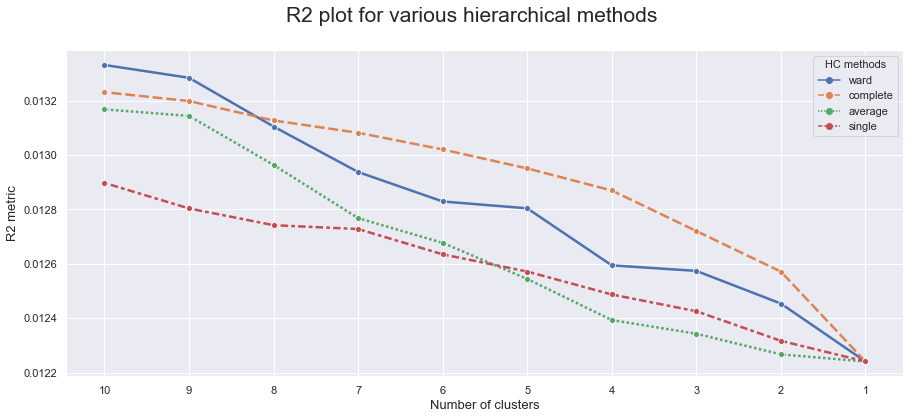

In [185]:
# Prepare input for the function above
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

# Call function defined above to obtain the R2 statistic for each hc_method
r2_hc_methods = np.vstack(
    [
        get_r2_hc(insur=insur[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)


# Plot data
sns.set()
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [234]:
# Setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'complete'
distance = 'euclidean'  #  If linkage is "ward", only "euclidean" is accepted.
# "euclidean", "l1", "l2", "manhattan", "cosine", or "precomputed".
    
# Also change the other parameters here !!!!!!!!!!!!!!!!!!
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(insur[metric_features])

array([10015,  8863,  8574, ...,     4,     1,     0], dtype=int64)

<ipython-input-235-7b05f8445723>:40: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



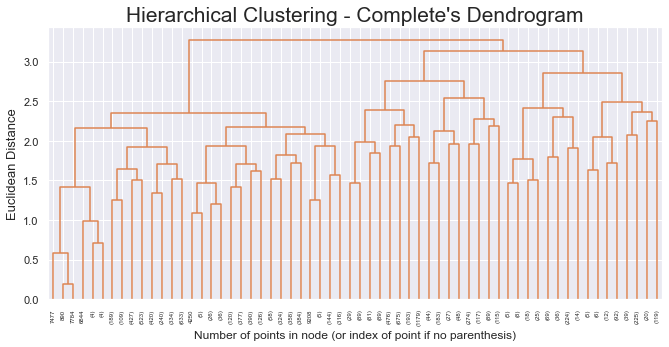

In [235]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)


# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 28
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [194]:
# 3 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(insur[metric_features])

In [195]:
# Characterizing the 3 clusters
insur_concat = pd.concat((insur, pd.Series(hc3_labels, name='labels')), axis=1)
insur_concat.groupby('labels').mean()

ClaimsRate  CustMonVal  FirstPolYear  MonthSal  PremHealth  \
labels                                                               
0.0       0.419856    0.379735      0.495784  0.461519    0.379773   
1.0       0.422496    0.374546      0.508644  0.467976    0.378925   
2.0       0.418460    0.379953      0.500729  0.461333    0.375835   

        PremHousehold  PremLife  PremMotor  PremWork  Client_Recency  ...  \
labels                                                                ...   
0.0          0.205946  0.144544   0.503005  0.145757        0.504216  ...   
1.0          0.199935  0.140120   0.511315  0.140176        0.491356  ...   
2.0          0.201588  0.138875   0.513444  0.143805        0.499271  ...   

        PremLife_Ratio_sqrt  PremWork_Ratio_sqrt  PremHousehold_Ratio_sqrt  \
labels                                                                       
0.0                0.286694             0.276348                  0.457155   
1.0                0.281371             0.269367                  0.447030   
2.0                0.278472             0.274119                  0.444510   

          x0_1.0    x1_2.0    x1_3.0    x1_4.0    x2_2.0    x2_3.0    x2_4.0  
labels                                                                        
0.0     0.713418  0.106051  0.198745  0.401943  0.106051  0.198745  0.401943  
1.0     0.698365  0.091763  0.200485  0.409146  0.091763  0.200485  0.409146  
2.0     0.704595  0.100656  0.205142  0.399344  0.100656  0.205142  0.399344  

[3 rows x 34 columns]

In [196]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(insur[metric_features])

In [197]:
# Characterizing the 3 clusters
insur_concat = pd.concat((insur, pd.Series(hc4_labels, name='labels')), axis=1)
insur_concat.groupby('labels').mean()

ClaimsRate  CustMonVal  FirstPolYear  MonthSal  PremHealth  \
labels                                                               
0.0       0.422496    0.374546      0.508644  0.467976    0.378925   
1.0       0.419707    0.379777      0.493946  0.461436    0.380451   
2.0       0.418460    0.379953      0.500729  0.461333    0.375835   
3.0       0.419997    0.379696      0.497532  0.461597    0.379128   

        PremHousehold  PremLife  PremMotor  PremWork  Client_Recency  ...  \
labels                                                                ...   
0.0          0.199935  0.140120   0.511315  0.140176        0.491356  ...   
1.0          0.205196  0.143904   0.501280  0.147578        0.506054  ...   
2.0          0.201588  0.138875   0.513444  0.143805        0.499271  ...   
3.0          0.206660  0.145152   0.504647  0.144024        0.502468  ...   

        PremLife_Ratio_sqrt  PremWork_Ratio_sqrt  PremHousehold_Ratio_sqrt  \
labels                                                                       
0.0                0.281371             0.269367                  0.447030   
1.0                0.286840             0.279275                  0.457556   
2.0                0.278472             0.274119                  0.444510   
3.0                0.286555             0.273564                  0.456774   

          x0_1.0    x1_2.0    x1_3.0    x1_4.0    x2_2.0    x2_3.0    x2_4.0  
labels                                                                        
0.0     0.698365  0.091763  0.200485  0.409146  0.091763  0.200485  0.409146  
1.0     0.721046  0.110419  0.207970  0.402242  0.110419  0.207970  0.402242  
2.0     0.704595  0.100656  0.205142  0.399344  0.100656  0.205142  0.399344  
3.0     0.706161  0.101896  0.189968  0.401659  0.101896  0.189968  0.401659  

[4 rows x 34 columns]

<a class="anchor" id="kmeans">

## 9.2. K-Means Algorithm
</a>

In [202]:
kmeans = KMeans(n_clusters=8, init='random', n_init=10, random_state=1) # change these parameters !!!!!!!!!!!!!

#            n_clusters=8,
#            *,
#            init='k-means++',
#            n_init=10,
#            max_iter=300,
#            tol=0.0001,
#            precompute_distances='deprecated',
#            verbose=0,
#            random_state=None,
#            copy_x=True,
#            n_jobs='deprecated',
#            algorithm='auto',

# the fit method
kmeans.fit(insur[metric_features])

# the predict method
kmeans.predict(insur[metric_features])

array([6, 3, 6, ..., 6, 6, 5])

In [203]:
# the transform method --> transform X to a cluster-distance space
pd.DataFrame(kmeans.transform(insur[metric_features]))

0         1         2         3         4         5         6  \
0      0.567786  1.078291  0.664158  0.896346  0.753908  1.356278  0.529469   
1      1.309951  0.683748  0.811609  0.602901  0.957728  1.002204  0.912881   
2      1.187170  0.977497  0.805386  1.007285  1.165160  1.427538  0.710610   
3      0.647483  1.023301  0.625297  0.950124  0.871002  1.418782  0.471801   
4      0.436898  1.454852  0.772830  1.206292  1.030653  1.758161  0.840429   
...         ...       ...       ...       ...       ...       ...       ...   
10178  0.584239  1.265438  0.958679  1.360398  0.886797  1.702372  0.790748   
10179  1.323055  1.102198  1.242081  1.564721  1.130736  1.764627  1.134463   
10180  0.849214  1.034879  1.058311  1.344769  1.076479  1.573449  0.737356   
10181  0.686634  1.375193  1.142951  1.223283  0.781308  1.391013  0.616037   
10182  1.964911  1.076406  1.488025  1.035875  1.523065  0.874692  1.373526   

              7  
0      0.603516  
1      1.106613  
2      1.016429  
3      0.630801  
4      0.464988  
...         ...  
10178  1.006509  
10179  1.611330  
10180  1.090010  
10181  1.111562  
10182  1.772938  

[10183 rows x 8 columns]

In [204]:
### How can we improve the initialization step?

# Better initialization method and provide more n_init
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmeans.fit(insur[metric_features])

KMeans(n_init=15, random_state=1)

<ipython-input-215-fd57b00a7bd8>:16: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



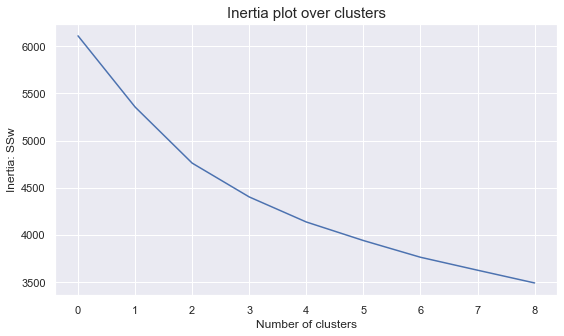

In [215]:
range_clusters = range(2, 11)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmeans = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmeans.fit(insur[metric_features])
    inertia.append(kmeans.inertia_)  # save the inertia of the given cluster solution
    
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [216]:
# Choose 3 clusters ???

For n_clusters = 2, the average silhouette_score is : 0.23659134321774292
For n_clusters = 3, the average silhouette_score is : 0.17276482636072002
For n_clusters = 4, the average silhouette_score is : 0.17019339112893128
For n_clusters = 5, the average silhouette_score is : 0.15228294271225246
For n_clusters = 6, the average silhouette_score is : 0.1554439260576245
For n_clusters = 7, the average silhouette_score is : 0.154496808973278
For n_clusters = 8, the average silhouette_score is : 0.15025366682402938
For n_clusters = 9, the average silhouette_score is : 0.1477647367040012
For n_clusters = 10, the average silhouette_score is : 0.147232927087677


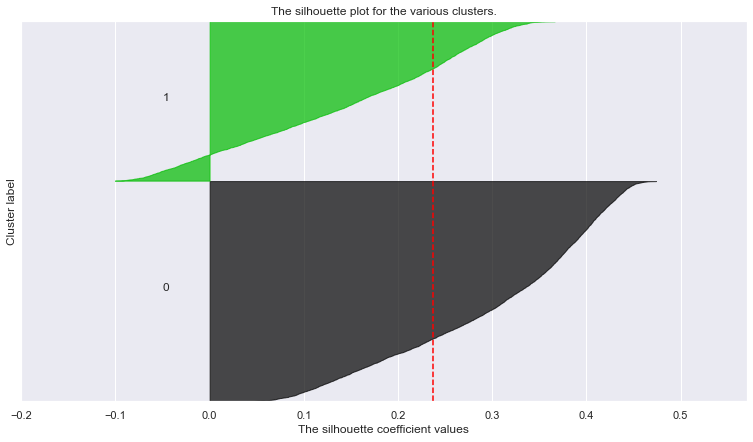

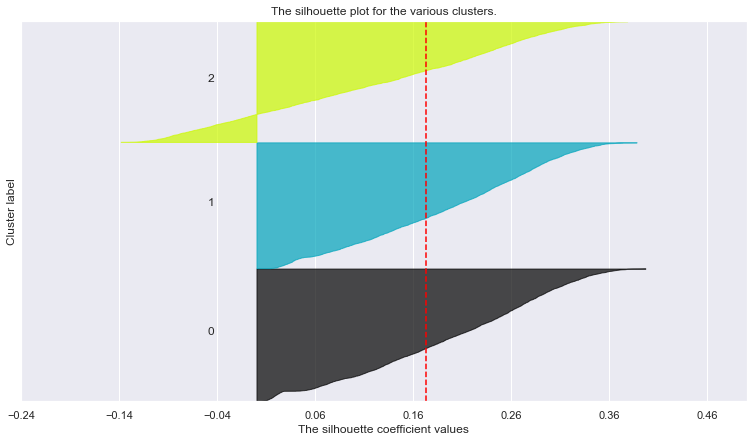

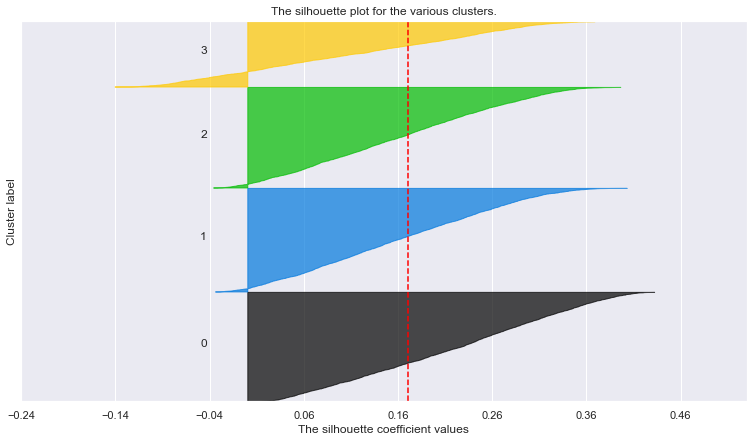

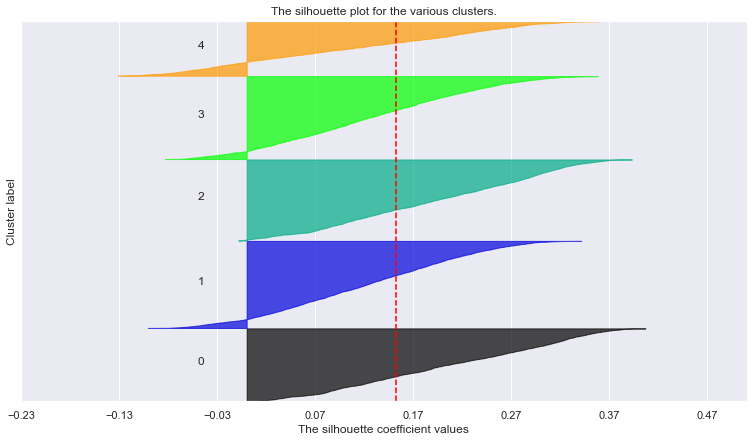

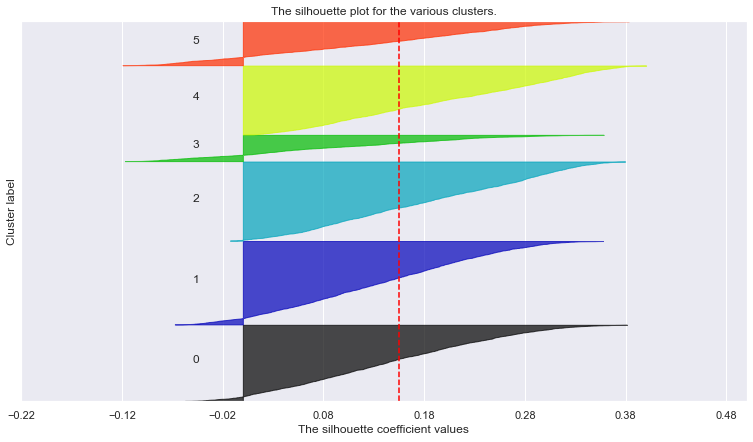

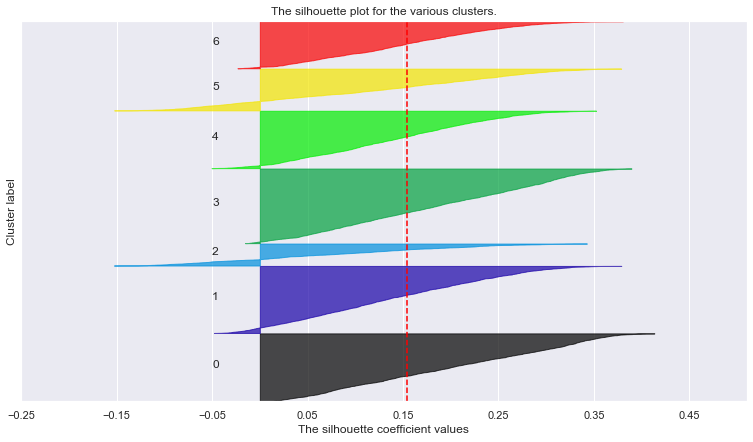

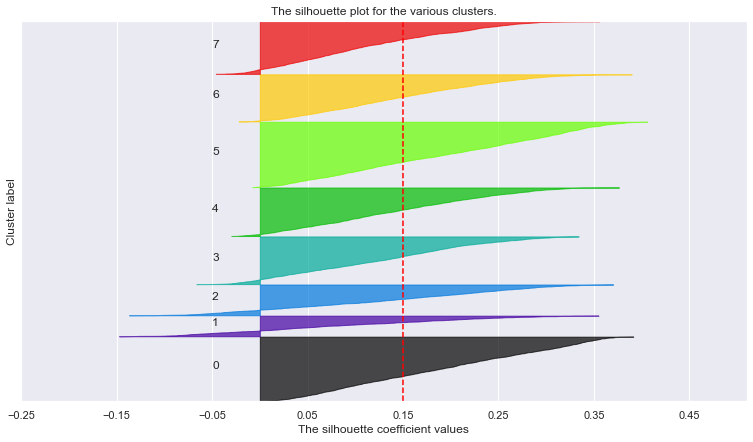

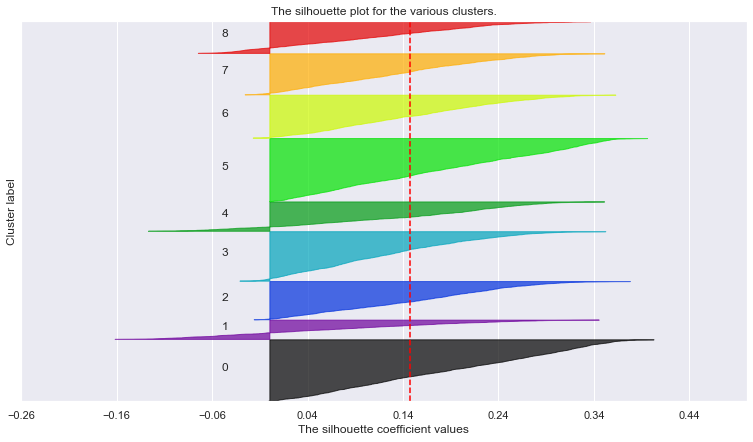

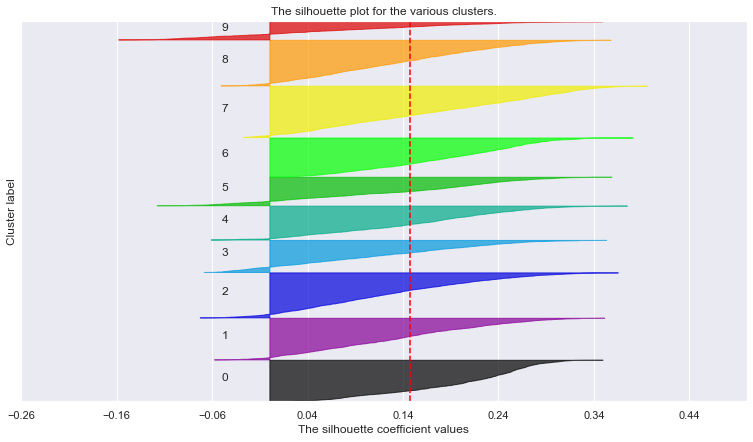

In [218]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmeans.fit_predict(insur[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(insur[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(insur[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(insur[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

In [219]:
# Analyse the graphics:
#    As n_clusters increase there are more negative silhouette values (observations that are closer to other clusters)
#    As n_clusters increase --> more condensed clusters
#    See the maximum silhouette_score --> n_clusters = 2 or 3


<ipython-input-220-b949a611bad5>:10: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



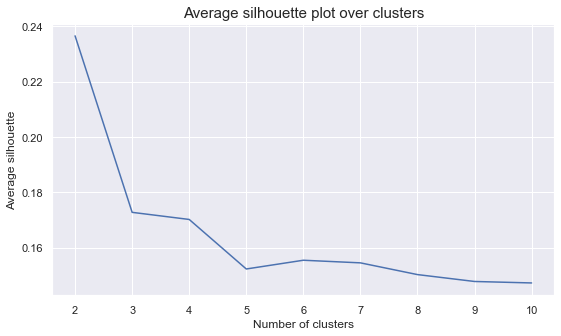

In [220]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))

plt.plot(pd.Series(avg_silhouette, index = range_clusters))

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [221]:
# final cluster solution
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(insur[metric_features])
km_labels

array([1, 0, 1, ..., 1, 1, 0])

In [222]:
# Characterizing the final clusters
insur_concat = pd.concat((insur, pd.Series(km_labels, name='labels')), axis=1)
insur_concat.groupby('labels').mean()

ClaimsRate  CustMonVal  FirstPolYear  MonthSal  PremHealth  \
labels                                                               
0.0       0.418592    0.380543      0.497189  0.454811    0.378615   
1.0       0.421839    0.376267      0.503610  0.470032    0.378901   

        PremHousehold  PremLife  PremMotor  PremWork  Client_Recency  ...  \
labels                                                                ...   
0.0          0.206021  0.144199   0.505282  0.144934        0.502811  ...   
1.0          0.201110  0.140503   0.509337  0.142578        0.496390  ...   

        PremLife_Ratio_sqrt  PremWork_Ratio_sqrt  PremHousehold_Ratio_sqrt  \
labels                                                                       
0.0                0.284683             0.274635                  0.454230   
1.0                0.282559             0.272938                  0.449573   

          x0_1.0    x1_2.0    x1_3.0    x1_4.0    x2_2.0    x2_3.0    x2_4.0  
labels                                                                        
0.0     0.716972  0.105078  0.202163  0.392337  0.105078  0.202163  0.392337  
1.0     0.699501  0.096957  0.199244  0.412240  0.096957  0.199244  0.412240  

[2 rows x 34 columns]

## K medoids !!!!

# DBSCAN


In [ ]:
# ======================
# SOCIODEMOGRAPHIC
# ======================

#insur_dbscan = insur.copy()
#
##Create dummy variables for education
#for elem in insur_dbscan['EducDeg'].unique():
#    insur_dbscan[str(elem)] = insur_dbscan['EducDeg'] == elem
#    
##normalize salary, for it to be in a scale from 0 to 1 like the binary variables
#salary = insur_dbscan[['Annual_Salary']]
#salary = (salary - salary.min()) / (salary.max() - salary.min())
#
#socio_view = pd.concat([insur_dbscan[['1.0','2.0','3.0','4.0','Children']],salary],axis=1).reindex()
#
#db = DBSCAN(eps=0.3, min_samples=100).fit(socio_view)
#labels = db.labels_
#
## Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#n_noise_ = list(labels).count(-1)
#
#unique_clusters, counts_clusters = np.unique(db.labels_, return_counts = True)
#print(np.asarray((unique_clusters, counts_clusters)))
#
#print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(socio_view, labels))
#
#
#pca = PCA(n_components=2).fit(socio_view)
#pca_2d = pca.transform(socio_view)
#for i in range(0, pca_2d.shape[0]):
#    if db.labels_[i] == 0:
#        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='rosybrown',marker='+')
#    elif db.labels_[i] == 1:
#        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
#    elif db.labels_[i] == 2:
#        c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='k',marker='v')
#    elif db.labels_[i] == 3:
#        c5 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='s')
#    elif db.labels_[i] == 4:
#        c6 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='m',marker='p')
#    elif db.labels_[i] == 5:
#        c7 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',marker='H')
#    elif db.labels_[i] == 6:
#        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
#    elif db.labels_[i] == 7:
#        c8 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='orange',marker='3')
#plt.legend([c1, c2, c3, c4,c5,c6,c7,c8], ['Cluster 1', 'Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8'],loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
#plt.title('DBSCAN found 8 clusters and no noise')
#plt.show()
#
#insur_dbscan.reset_index(drop=True, inplace=True) 
#labels = pd.DataFrame(labels)
#labels.columns =  ['Value']
#results_socio=pd.concat([labels,insur_dbscan],axis=1)
#
#fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(15,35))
#
## cluster 1
#axs[0, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==0], color='darkseagreen',range=[1,4])
#axs[0, 0].set_title('Education for Cluster 1')
#plt.sca(axs[0, 0])
#plt.xticks([1, 2, 3, 4])
#axs[0, 1].hist(results_socio['Children'].loc[results_socio['Value']==0], color='cadetblue',range=[0,1])
#axs[0, 1].set_title('Children for Cluster 1')
#plt.sca(axs[0, 1])
#plt.xticks([0,1])
#axs[0, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==0], color='tan', range=[1000,60000])
#axs[0, 2].set_title('Annual_Salary for Cluster 1')
#
## cluster 2
#axs[1, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==1], color='darkseagreen',range=[1,4])
#axs[1, 0].set_title('Education for Cluster 2')
#plt.sca(axs[1, 0])
#plt.xticks([1, 2, 3, 4])
#axs[1, 1].hist(results_socio['Children'].loc[results_socio['Value']==1], color='cadetblue',range=[0,1])
#axs[1, 1].set_title('Children for Cluster 2')
#plt.sca(axs[1, 1])
#plt.xticks([0,1])
#axs[1, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==1], color='tan', range=[1000,60000])
#axs[1, 2].set_title('Annual_Salary for Cluster 2')
#
## cluster 3
#axs[2, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==2], color='darkseagreen',range=[1,4])
#axs[2, 0].set_title('Education for Cluster 3')
#plt.sca(axs[2, 0])
#plt.xticks([1, 2, 3, 4])
#axs[2, 1].hist(results_socio['Children'].loc[results_socio['Value']==2], color='cadetblue',range=[0,1])
#axs[2, 1].set_title('Children for Cluster 3')
#plt.sca(axs[2, 1])
#plt.xticks([0,1])
#axs[2, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==2], color='tan', range=[1000,60000])
#axs[2, 2].set_title('Annual_Salary for Cluster 3')
#
## cluster 4
#axs[3, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==3], color='darkseagreen',range=[1,4])
#axs[3, 0].set_title('Education for Cluster 4')
#plt.sca(axs[3, 0])
#plt.xticks([1, 2, 3, 4])
#axs[3, 1].hist(results_socio['Children'].loc[results_socio['Value']==3], color='cadetblue',range=[0,1])
#axs[3, 1].set_title('Children for Cluster 4')
#plt.sca(axs[3, 1])
#plt.xticks([0,1])
#axs[3, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==3], color='tan', range=[1000,60000])
#axs[3, 2].set_title('Annual_Salary for Cluster 4')
#
## cluster 5
#axs[4, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==4], color='darkseagreen',range=[1,4])
#axs[4, 0].set_title('Education for Cluster 5')
#plt.sca(axs[4, 0])
#plt.xticks([1, 2, 3, 4])
#axs[4, 1].hist(results_socio['Children'].loc[results_socio['Value']==4], color='cadetblue',range=[0,1])
#axs[4, 1].set_title('Children for Cluster 5')
#plt.sca(axs[4, 1])
#plt.xticks([0,1])
#axs[4, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==4], color='tan', range=[1000,60000])
#axs[4, 2].set_title('Annual_Salary for Cluster 5')
#
## cluster 6
#axs[5, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==5], color='darkseagreen',range=[1,4])
#axs[5, 0].set_title('Education for Cluster 6')
#plt.sca(axs[5, 0])
#plt.xticks([1, 2, 3, 4])
#axs[5, 1].hist(results_socio['Children'].loc[results_socio['Value']==5], color='cadetblue',range=[0,1])
#axs[5, 1].set_title('Children for Cluster 6')
#plt.sca(axs[5, 1])
#plt.xticks([0,1])
#axs[5, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==5], color='tan', range=[1000,60000])
#axs[5, 2].set_title('Annual_Salary for Cluster 6')
#
## cluster 7
#axs[6, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==6], color='darkseagreen',range=[1,4])
#axs[6, 0].set_title('Education for Cluster 7')
#plt.sca(axs[6, 0])
#plt.xticks([1, 2, 3, 4])
#axs[6, 1].hist(results_socio['Children'].loc[results_socio['Value']==6], color='cadetblue',range=[0,1])
#axs[6, 1].set_title('Children for Cluster 7')
#plt.sca(axs[6, 1])
#plt.xticks([0,1])
#axs[6, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==6], color='tan', range=[1000,60000])
#axs[6, 2].set_title('Annual_Salary for Cluster 7')
#
## cluster 8
#axs[7, 0].hist(results_socio['EducDeg'].loc[results_socio['Value']==7], color='darkseagreen',range=[1,4])
#axs[7, 0].set_title('Education for Cluster 8')
#plt.sca(axs[7, 0])
#plt.xticks([1, 2, 3, 4])
#axs[7, 1].hist(results_socio['Children'].loc[results_socio['Value']==7], color='cadetblue',range=[0,1])
#axs[7, 1].set_title('Children for Cluster 8')
#plt.sca(axs[7, 1])
#plt.xticks([0,1])
#axs[7, 2].hist(results_socio['Annual_Salary'].loc[results_socio['Value']==7], color='tan', range=[1000,60000])
#axs[7, 2].set_title('Annual_Salary for Cluster 8')
#
#plt.show()
#

In [ ]:
def get_ss(insur):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(insur.var() * (insur.count() - 1))
    return ss  # return sum of sum of squares of each insur variable

Mean Shift

In [ ]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(insur[metric_features], quantile=0.002, random_state=1, n_jobs=-1)
bandwidth

# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(insur[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

In [ ]:
# Concatenating the labels to insur
insur_concat = pd.concat([insur[metric_features], pd.Series(ms_labels, index=insur.index, name="ms_labels")], axis=1)
insur_concat.head()

# Computing the R^2 of the cluster solution
sst = get_ss(insur[metric_features])  # get total sum of squares
ssw_labels = insur_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

DBSCAN

In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.002, min_samples=20, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(insur[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

In [ ]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(insur[metric_features])
distances, _ = neigh.kneighbors(insur[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [ ]:
# Concatenating the labels to insur
insur_concat = pd.concat([insur[metric_features], pd.Series(dbscan_labels, index=insur.index, name="dbscan_labels")], axis=1)
insur_concat.head()

In [ ]:
# Detecting noise (potential outliers)
insur_concat.loc[insur_concat['dbscan_labels'] == -1]

In [ ]:
# Computing the R^2 of the cluster solution
insur_nonoise = insur_concat.loc[insur_concat['dbscan_labels'] != -1]
sst = get_ss(insur[metric_features])  # get total sum of squares
ssw_labels = insur_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)